<a href="https://colab.research.google.com/github/mrdbourke/tensorflow-deep-learning/blob/main/02_neural_network_classification_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Phân loại mạng nơ-ron với TensorFlow

Chúng ta đã thấy cách giải bài toán hồi quy trong TensorFlow, hãy xem cách tiếp cận bài toán phân loại.

[Bài toán phân loại](https://en.wikipedia.org/wiki/Statistical_classification) sẽ dự đoán xem một thứ là điều này hay điều khác.

Ví dụ, chúng ta có thể:
* Đoán xem ai đó có bị bệnh tim hay không dựa trên các tham số về sức khỏe. Do chỉ có 2 lựa chọn nên đó là **binary classification (phân loại nhị phân)**.
* Quyết định xem bức ảnh là về thức ăn, người hay chó. Vì có nhiều hơn hai lựa chọn nên đây là **multi-class classification (phân loại đa lớp)**.
* Đoán xem hạng mục nào sẽ được chỉ định cho bài viết Wikipedia. Vì một bài viết riêng lẻ có nhiều hơn một hạng mục được chỉ định nên đây là **multi-label classification (phân loại đa nhãn)**

Trong notebook này, chúng ta sẽ xem xét nhiều bài toán phân loại khác nhau với TensorFlow. Nói cách khác, chúng ta sẽ lấy một tập hợp đầu vào và dự đoán xem tập hợp đó thuộc lớp nào.

## Những điều chúng ta sẽ tìm hiểu

Cụ thể, chúng ta sẽ xem xét những điều sau với TensorFlow:
- Kiến trúc của mô hình phân loại
- Shape của đầu vào/đầu ra
  - `X`: đặc trưng/dữ liệu (đầu vào)
  - `y`: nhãn (đầu ra)
    - "Các input thuộc lớp nào?"
- Tạo dữ liệu tùy chỉnh để xem và điều chỉnh
- Các bước lập mô hình phân loại nhị phân và phân loai đa lớp
  - Tạo mô hình
  - Biên dịch mô hình
    - Định nghĩa hàm mất mát
    - Thiết lập optimizer
      - Tìm tốc độ học tốt nhất
    - Tạo các phép đo đánh giá
  - Khớp mô hình (để tìm pattern trong dữ liệu)
  - Cải thiện mô hình
- Khả năng của non-linearity
- Đánh giá mô hình phân loại
  - Trực quan hóa mô hình ("visualize, visualize, visualize")
  - Quan sát đồ thị huấn luyện
  - So sánh các dự đoán với nhãn gốc (sử dụng các phép đo đánh giá)

## Cách sử dụng notebook này

Các bạn có thể đọc qua các mô tả và code (tất cả sẽ chạy, trừ những cell mắc lỗi có chủ đích), nhưng có một lựa chọn tốt hơn.

Tự viết toàn bộ code.

Nghiêm túc đấy. Hãy tạo notebook mới và tự viết lại từng dòng. Kiểm tra xem bạn có thể thay đổi nó không và lý do cho điều đó.

Bạn không cần viết mô tả bằng văn bản nhưng tự viết lại code là một cách tuyệt vời để có trải nghiệm thực tiễn.

Đừng lo lắng nếu mắc sai sót, ai cũng đều mắc lỗi cả. Cách thực hiện tốt hơn và mắc ít lỗi hơn là **viết nhiều code hơn**.

## Kiến trúc điển hình của mạng nơ-ron phân loại

Từ *điển hình* ở đây được sử dụng có chủ đích.

Kiến trúc của mạng nơ-ron phân loại thay đổi rộng rãi tùy thuộc vào bài toán mà chúng ta đang giải.

Tuy nhiên, tất cả các mạng nơ-ron sâu đều gồm những thành phần cơ bản sau:
* Một lớp đầu vào.
* Một số lớp ẩn.
* Một lớp đầu ra.

Đa số phần còn lại tùy theo nhà phân tích dữ liệu tạo ra mô hình.

Dưới đây là một số giá trị tiêu chuẩn mà chúng ta thường dùng trong các mạng nơ-ron phân loại.

| **Siêu tham số** | **Phân loại nhị phân** | **Phân loại đa lớp** |
| --- | --- | --- |
| Shape của lớp đầu vào | Tương đương với số đặc trưng (chẳng hạn: 5 cho age, sex, height, weight, smoking status trong dự đoán bệnh tim) | Tương tự như phân loại nhị phân |
| (Các) lớp ẩn | Bài toán cụ thể, min = 1, max = không giới hạn | Tương tự như phân loại nhị phân |
| Nơ-ron mỗi lớp ẩn | Bài toán cụ thể, thường từ 10 tới 100 | Tương tự như phân loại nhị phân |
| Shape của lớp đầu ra | 1 (lớp này hoặc lớp khác) | 1 mỗi lớp (ví dụ: 3 cho food, person hoặc dog photo) |
| Kích hoạt ẩn | Thường là [ReLU](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning) (rectified linear unit) | Tương tự như phân loại nhị phân |
| Kích hoạt đầu ra | [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) | [Softmax](https://en.wikipedia.org/wiki/Softmax_function) |
| Hàm mất mát | [Cross entropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) ([`tf.keras.losses.BinaryCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) trong TensorFlow) | Cross entropy ([`tf.keras.losses.CategoricalCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) trong TensorFlow) |
| Optimizer | [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) (stochastic gradient descent), [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) | Tương tự như phân loại nhị phân |

***Bảng 1:*** *Kiến trúc điển hình của mạng phân loại.* ***Nguồn:*** *Trích từ [Aurélien Géron. "Hands-On Machine Learning with Scikit-Learn", Keras & TensorFlow, trang 295](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/).*

Đừng lo nếu bạn chưa nắm rõ những điều trên, chúng ta sẽ hiểu rõ hơn khi nghiên cứu notebook này.

Hãy bắt đầu bằng cách import TensorFlow với alias thường gặp là `tf`. Đảm bảo dùng phiên bản 2.x+ cho notebook này.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.15.0


## Tạo dữ liệu để xem và điều chỉnh

Chúng ta sẽ bắt đầu bằng cách import một tập dữ liệu phân loại nhưng cũng hãy thực hành tạo dữ liệu phân loại của riêng bạn.

> 🔑 **Lưu ý:** Đây là cách giúp mô hình của chúng ta hoạt động trên một tập dữ liệu giả lập trước khi chuyển sang bài toán thực tế. Coi nó như một thử nghiệm diễn tập trước khi thử nghiệm thực tế.


Vì bài toán phân loại dự đoán xem một thứ là thứ này hay thứ khác nên hãy tạo một số dữ liệu để phản ánh điều đó.

Hãy sử dụng hàm [`make_circles()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html#sklearn.datasets.make_circles) của Scikit-learn để thực hiện điều đó.



In [ ]:
from sklearn.datasets import make_circles

# Tạo 100 mẫu
n_samples = 1000

# Tạo circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

Tuyệt, chúng ta đã tạo một số dữ liệu, hãy xem các đặc trưng (`X`) và nhãn (`y`).

In [ ]:
# Kiểm tra các đặc trưng
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [ ]:
# Xem 10 nhãn đầu tiên
y[:10]

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0])

Chúng ta đã thấy dữ liệu và các nhãn, hãy chuyển sang phần trực quan.

> 🔑 **Lưu ý:** Một bước quan trọng khi bắt đầu bất cứ dự án học máy nào là [trở thành một với dữ liệu](https://karpathy.github.io/2019/04/25/recipe/). Cách tốt nhất để thực hiện điều này là trực quan hóa dữ liệu mà chúng ta đang làm việc nhiều nhất có thể. Phương châm của data explorer là "visualize, visualize, visualize".

Chúng ta sẽ bắt đầu với DataFrame.

In [ ]:
# Tạo dataframe có các đặc trưng và nhãn
import pandas as pd
circles = pd.DataFrame({"X0":X[:, 0], "X1":X[:, 1], "label":y})
circles.head()

,X0,X1,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


Chúng ta đang xử lý những loại nhãn nào?

In [ ]:
# Kiểm tra các nhãn khác nhau
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

Trông giống như chúng ta đang giải bài toán **phân loại nhị phân**, vì chỉ có hai nhãn (0 hoặc 1).

Nếu có nhiều hơn 2 lựa chọn về nhãn (chẳng hạn: 0, 1, 2, 3 hoặc 4) thì đó là **phân loại đa lớp**.

Hãy hình dùng thêm và vẽ biểu đồ dữ liệu.


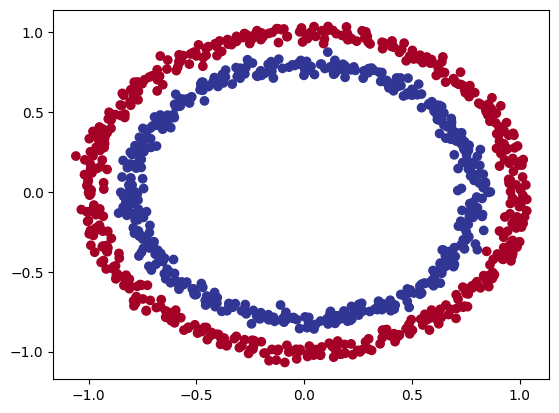

In [ ]:
# Trực quan hóa với biểu đồ
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

Tuyệt! Các bạn có thể đoán chúng ta muốn xây dựng kiểu mô hình nào từ biểu đồ không?

 Vậy chúng ta có nên thử xây dựng một mô hình để phân loại các chấm xanh và đỏ không? Như trong mô hình, chúng ta có thể phân tách các chấm xanh và đỏ.

> 🛠 **Thực hành:** Trước khi tiếp tục, chúng ta cần dành 10 phút thử với [TensorFlow Playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=2,2&seed=0.93799&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&regularizationRate_hide=true&batchSize_hide=true). Hãy thử điều chỉnh các siêu tham số khác nhau mà bạn thấy và click play để xem mạng nơ-ron huấn luyện. Tôi nghĩ các bạn sẽ tìm thấy dữ liệu rất giống với dữ liệu mà chúng ta vừa tạo.

## Shape của đầu vào và đầu ra

Một trong những vấn đề phổ biến nhất mà chúng ta sẽ gặp khi xây dựng mạng nơ-ron là shape không khớp.

Cụ thể là shape của dữ liệu đầu vào và dữ liệu đầu ra.

Trong trường hợp này, chúng ta muốn nhập `X` và có được mô hình để dự đoán `y`.

Hãy kiểm tra shape của `X` và `y`.

In [ ]:
# Kiểm tra shape của các đặc trưng và nhãn
X.shape, y.shape

((1000, 2), (1000,))

Những số này đến từ đâu?

In [ ]:
# Kiểm tra xem chúng ta có bao nhiêu mẫu
len(X), len(y)

(1000, 1000)

Như vậy chúng ta có số lượng giá trị `X` bằng với số lượng giá trị `y`, điều này hợp lý.

Hãy kiểm tra một ví dụ của từng loại.

In [ ]:
# Xem mẫu đầu đặc trưng và nhãn đầu tiên
X[0], y[0]

(array([0.75424625, 0.23148074]), 1)

Chúng ta có hai đặc trưng `X` dẫn tới một giá trị `y`.

Điều này có nghĩa là shape đầu vào của mạng nơ-ron sẽ phải chấp nhận một tensor có ít nhất một chiều là hai và xuất ra một tensor có ít nhất một giá trị.

> 🤔 **Lưu ý:** `y` có shape là 1000, điều này có vẻ khó hiểu. Tuy nhiên, đó là vì tất cả các giá trị `y` thực ra là các số vô hướng (các giá trị đơn lẻ) nên không có chiều. Bây giờ hãy nghĩ rằng shape đầu ra ít nhất là các giá trị tương tự như một mẫu của `y` (trong trường hợp này, đầu ra từ mạng nơ-ron ít nhất phải là giá trị một).

## Các bước lập mô hình

Chúng ta đã biết dữ liệu mà chúng ta có với shape của đầu vào/đầu ra, hãy xem cách xây dựng mạng nơ-ron để lập mô hình.

Trong TensorFlow, thường có 3 bước cơ bản để tạo và huấn luyện một mô hình.

1. **Tạo mô hình** - tự ghép các lớp của mạng nơ-ron lại với nhau (sử dụng [functional](https://www.tensorflow.org/guide/keras/functional) hoặc [sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)) hoặc import mô hình đã tạo trước đó (còn gọi là học truyền tải).
2. **Biên dịch mô hình** - xác định cách đo lường chất lượng mô hình (loss/các phép đo) cũng như cách cải thiện mô hình (optimizer).
3. **Khớp mô hình** - cho mô hình thử tìm pattern trong dữ liệu (cách để `X` tới được `y`).

Hãy xem cách triển khai chúng bằng Sequential API để xây một mô hình cho dữ liệu hồi quy, sau đó chúng ta sẽ đi qua từng bước.

In [ ]:
# Thiết lập random seed
tf.random.set_seed(42)

# 1. Tạo mô hình sử dụng Sequential API
model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(1)
])

# 2. Biên dịch mô hình
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(), # là nhị phân vì chúng ta chỉ hoạt động với 2 lớp (0 và 1)
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['accuracy'])

# 3. Khớp mô hình
model_1.fit(X, y, epochs=5)

Epoch 1/5
32/32 [==============================] - 1s 2ms/step - loss: 6.2526 - accuracy: 0.4860
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 6.7737 - accuracy: 0.5060
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 6.7754 - accuracy: 0.4450
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 6.1737 - accuracy: 0.4100
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 6.2005 - accuracy: 0.4230


Quan sát phép đo accuracy (độ chính xác), chúng ta thấy mô hình thực hiện kém (độ chính xác 50% trong bài toán phân loại nhị phân tương đương với việc đoán), nhưng nếu chúng ta huấn luyện lâu hơn thì điều gì sẽ xảy ra?

In [ ]:
# Huấn luyện mô hình lâu hơn (nhiều cơ hội xem dữ liệu hơn)
model_1.fit(X, y, epochs=200, verbose=0) # đặt verbose=0 để loại các cập nhật huấn luyện
model_1.evaluate(X, y)

32/32 [==============================] - 0s 1ms/step - loss: 0.6935 - accuracy: 0.5000


[0.6934831142425537, 0.5]

Sau 200 lần truyền dữ liệu, nó vẫn thực hiện như thể đang đoán.

Điều gì sẽ xảy ra nếu chúng ta thêm một lớp bổ sung và huấn luyện lâu hơn chút nữa?

In [ ]:
# Thiết lập random seed
tf.random.set_seed(42)

# 1. Tạo mô hình (tương tự model_1 nhưng thêm một lớp)
model_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(1), # thêm một lớp
  tf.keras.layers.Dense(1)
])

# 2. Biên dịch mô hình
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['accuracy'])

# 3. Khớp mô hình
model_2.fit(X, y, epochs=100, verbose=0) # đặt verbose=0 để in ra ít kết quả hơn

In [ ]:
# Đánh giá mô hình
model_2.evaluate(X, y)

32/32 [==============================] - 0s 1ms/step - loss: 0.6933 - accuracy: 0.5000


[0.6932797431945801, 0.5]

Vẫn không tốt bằng việc đoán (độ chính xác ~50%).

Nhắc lại một số cách cải thiện mô hình.

## Cải thiện mô hình

Để cải thiện mô hình, chúng ta sẽ thay đổi hầu hết mọi phần của 3 bước mà chúng ta đã xét trước đó.

1. **Tạo mô hình** - ở đây có thể chúng ta muốn thêm nhiều lớp, tăng số đơn vị ẩn (hay còn gọi là nơ-ron) trong từng lớp, thay đổi hàm kích hoạt của từng lớp.
2. **Biên dịch mô hình** -  chúng ta có thể chọn một hàm tối ưu khác (chẳng hạn như [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam), hàm này khá tốt với nhiều bài toán) hoặc thay đổi tốc độ học của hàm tối ưu.
3. **Khớp mô hình** - chúng ta có thể khớp mô hình cho nhiều epoch hơn (để huấn luyện lâu hơn).

![various options you can use to improve a neural network model](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-improving-a-model-from-model-perspective.png)
*Có nhiều cách khác nhau để cải thiện mạng nơ-ron. Một số cách phổ biến nhất gồm: tăng số lớp (làm cho mạng sâu hơn), tăng số đơn vị ẩn (làm cho mạng rộng hơn) và thay đổi tốc độ học. Do các giá trị này đều có thể thay đổi nên chúng là các [hyperparameter (siêu tham số)](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)) và việc cố gắng tìm ra siêu tham số tốt nhất được gọi là [điều chỉnh siêu tham số](https://en.wikipedia.org/wiki/Hyperparameter_optimization).*

Vậy chúng ta có nên thêm nhiều nơ-ron, một lớp bổ sung và thuật toán tối ưu Adam?

Chắc chắn thực hiện điều này sẽ cho kết quả dự đoán tốt hơn việc đoán...

In [ ]:
# Thiết lập random seed
tf.random.set_seed(42)

# 1. Tạo mô hình (lần này là 3 lớp)
model_3 = tf.keras.Sequential([
  tf.keras.layers.Dense(100), #  thêm 100 nơ-ron dày
  tf.keras.layers.Dense(10), # thêm một lớp khác có 10 nơ-ron
  tf.keras.layers.Dense(1)
])

# 2. Biên dịch mô hình
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(), # sử dụng Adam thay vì SGD
                metrics=['accuracy'])

# 3. Khớp mô hình
model_3.fit(X, y, epochs=100, verbose=0) # khớp 100 lượt dữ liệu

Vẫn vậy!

Chúng ta đã đưa ra một số thủ thuật nhưng mô hình không hoạt động tốt hơn việc đoán.

Hãy hiển thị những gì đang diễn ra.

> 🔑 **Lưu ý:** Bất cứ khi nào mô hình hoạt động không bình thường hoặc có thứ gì xảy ra với dữ liệu mà bạn không chắc chắn, hãy nhớ 3 từ sau: **visualize, visualize, visualize (trực quan hóa)**. Kiểm tra dữ liệu, mô hình và các dự đoán của mô hình.

Để hiển thị các dự đoán của mô hình, chúng ta sẽ tạo hàm `plot_decision_boundary()`:
* Lấy mô hình đã huấn luyện, đặc trưng (`X`) và nhãn (`y`).
* Tạo [meshgrid](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html) của các giá trị `X` khác nhau.
* Đưa ra dự đoán trên meshgrid.
* Vẽ biểu đồ dự đoán cũng như đường thẳng giữa các vùng khác nhau (nơi mà từng lớp duy nhất nằm ở đó).

Điều này có vẻ khó hiểu, hãy xem trong code rồi xem kết quả.

> 🔑 **Lưu ý:** Nếu không chắc hàm thực hiện những gì, hãy thử phân tích và tự viết từng dòng để xem nó hoạt động như thế nào. Chia thành các phần nhỏ và xem mỗi phần xuất ra những gì.

In [ ]:
import numpy as np

def plot_decision_boundary(model, X, y):
  """
  Vẽ biểu đồ ranh giới quyết định do mô hình dự đoán trên X tạo ra.
  Hàm này được mô phỏng từ 2 nguồn:
   1. CS231n - https://cs231n.github.io/neural-networks-case-study/
   2. Made with ML basics - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
  """
  # Define the axis boundaries of the plot and create a meshgrid Xác định ranh giới trục của biểu đồ và tạo meshgrid
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))

  # Tạo các giá trị X (chúng ta sẽ dự đoán trên tất cả các giá trị)
  x_in = np.c_[xx.ravel(), yy.ravel()] # chồng các mảng 2D với nhau: https://numpy.org/devdocs/reference/generated/numpy.c_.html

  # Đưa ra dự đoán sử dụng mô hình đã huấn luyện
  y_pred = model.predict(x_in)

  # Kiểm tra cho đa lớp
  if len(y_pred[0]) > 1:
    print("doing multiclass classification...")
    # Chúng ta cần reshape các dự đoán để chuẩn bị vẽ biểu đồ
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
  else:
    print("doing binary classifcation...")
    y_pred = np.round(y_pred).reshape(xx.shape)

  # Vẽ biểu đồ ranh giới quyết định
  plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

Chúng ta đã có một hàm để vẽ biểu đồ ranh giới quyết định (điểm phân tách các chấm đỏ và chấm xanh), hãy thử thôi.

313/313 [==============================] - 0s 1ms/step
doing binary classifcation...


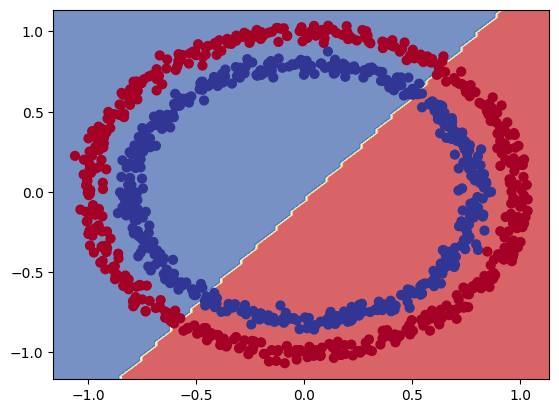

In [ ]:
# Kiểm tra các dự đoán mà mô hình đưa ra
plot_decision_boundary(model_3, X, y)

Có vẻ như mô hình đang cố gắng vẽ một đường thẳng qua dữ liệu.

Có gì sai ở đây vậy?

Vấn đề chính là dữ liệu không thể phân tách bằng một đường thẳng.

Trong bài toán hồi quy, mô hình có thể hoạt động. Hãy thử thôi.

In [ ]:
# Thiết lập random seed
tf.random.set_seed(42)

# Tạo một số dữ liệu hồi quy
X_regression = np.arange(0, 1000, 5)
y_regression = np.arange(100, 1100, 5)

# Chia thành tập huấn luyện và tập kiểm tra
X_reg_train = X_regression[:150]
X_reg_test = X_regression[150:]
y_reg_train = y_regression[:150]
y_reg_test = y_regression[150:]


X_reg_train = X_reg_train.reshape(-1,1)
X_reg_test = X_reg_test.reshape(-1,1)
# Khớp mô hình với dữ liệu
# model_3.fit(X_reg_train, y_reg_train, epochs=100)

In [ ]:
X_regression

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
       130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190,
       195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255,
       260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320,
       325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385,
       390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450,
       455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515,
       520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580,
       585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645,
       650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710,
       715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775,
       780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840,
       845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 90

Đợi chút...chúng ta đã biên dịch mô hình cho bài toán phân loại nhị phân.

Không thành vấn đề, chúng ta cũng có thể làm lại cho bài toán hồi quy.

In [ ]:
# Thiết lập random seed
tf.random.set_seed(42)

# Tạo lại mô hình
model_3 = tf.keras.Sequential([
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(10),
  tf.keras.layers.Dense(1)
])

# Thay đổi loss và metrics của mô hình đã biên dịch
model_3.compile(loss=tf.keras.losses.mae, # đổi hàm mất mát thành hồi quy cụ thể
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae']) # đổi metrics thành hồi quy cụ thể

# Khớp mô hình đã biên dịch
model_3.fit(X_reg_train, y_reg_train, epochs=100)

Epoch 1/100
5/5 [==============================] - 1s 4ms/step - loss: 365.4592 - mae: 365.4593
Epoch 2/100
5/5 [==============================] - 0s 3ms/step - loss: 214.8449 - mae: 214.8449
Epoch 3/100
5/5 [==============================] - 0s 3ms/step - loss: 76.5293 - mae: 76.5293
Epoch 4/100
5/5 [==============================] - 0s 4ms/step - loss: 79.0798 - mae: 79.0798
Epoch 5/100
5/5 [==============================] - 0s 3ms/step - loss: 84.1451 - mae: 84.1451
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 49.2827 - mae: 49.2827
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 52.4336 - mae: 52.4336
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 42.4987 - mae: 42.4987
Epoch 9/100
5/5 [==============================] - 0s 3ms/step - loss: 45.9551 - mae: 45.9551
Epoch 10/100
5/5 [==============================] - 0s 3ms/step - loss: 42.8691 - mae: 42.8691
Epoch 11/100
5/5 [==============================] - 0s 

Có vẻ như mô hình đang học được điều gì đó (giá trị `mae` có xu hướng giảm theo từng epoch), hãy vẽ biểu đồ các dự đoán của nó.

2/2 [==============================] - 0s 6ms/step


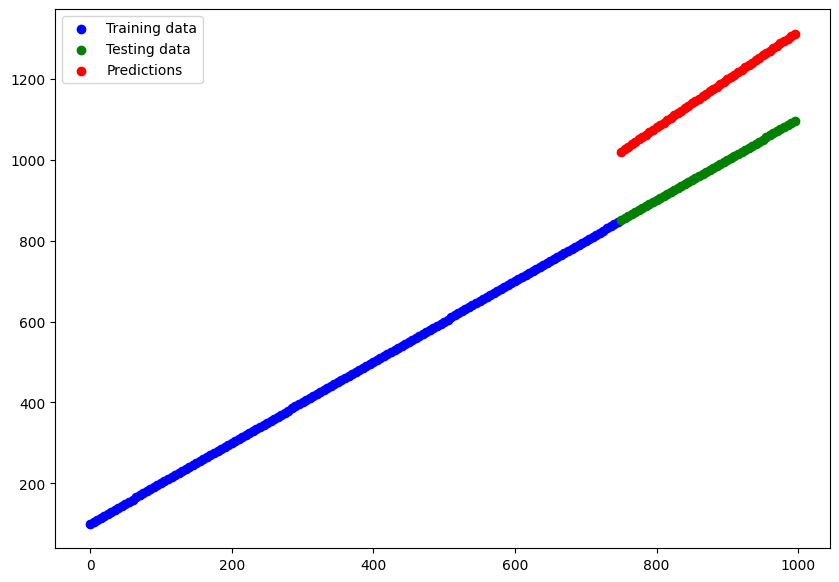

In [ ]:
# Đưa ra dự đoán với mô hình đã huấn luyện
y_reg_preds = model_3.predict(y_reg_test)

# Vẽ các dự đoán của mô hình so với dữ liệu hồi quy
plt.figure(figsize=(10, 7))
plt.scatter(X_reg_train, y_reg_train, c='b', label='Training data')
plt.scatter(X_reg_test, y_reg_test, c='g', label='Testing data')
plt.scatter(X_reg_test, y_reg_preds.squeeze(), c='r', label='Predictions')
plt.legend();

Các dự đoán không hoàn hảo (nếu dự đoán hoàn hảo, màu đỏ sẽ thẳng hàng với màu xanh lá), nhưng chúng trông đẹp hơn đoán hoàn toàn.

Điều này có nghĩa là mô hình đã học được điều gì đó ...

Chắc hẳn chúng ta đang bỏ lỡ điều gì đó cho bài toán phân loại.

## Phần còn thiếu: Non-linearity

Chúng ta đã thấy mạng nơ-ron có thể lập mô hình các đường thẳng (khả năng tốt hơn một chút so với việc đoán)/

Vậy còn các đường không thẳng (phi tuyến tính) thì sao?

Chúng ta sẽ lập mô hình dữ liệu phân loại (các vòng tròn đỏ và xanh dương), cần một số đường phi tuyến tính.

> 🔨 **Thực hành:** Trước khi sang bước tiếp theo, các bạn hãy thử với [TensorFlow Playground](https://playground.tensorflow.org/#activation=linear&batchSize=1&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=1&seed=0.09561&showTestData=false&discretize=false&percTrainData=70&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularizationRate_hide=true&discretize_hide=true&regularization_hide=true&dataset_hide=true&noise_hide=true&batchSize_hide=true) (kiểm tra dữ liệu có điểm chung gì với dữ liệu phân loại của chúng ta) khoảng 10 phút. Đặc biệt là tab có nội dung "activation" và quay lại sau khi xong.


Các bạn đã thử các tùy chọn activation chưa? Nếu đã thử thì các bạn đã thấy những gì?

Nếu chưa cũng đừng lo, chúng ta sẽ thấy trong code.

Chúng ta sẽ tạo bản sao mạng nơ-ron ở link sau: [TensorFlow Playground](https://playground.tensorflow.org/#activation=linear&batchSize=1&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=1&seed=0.09561&showTestData=false&discretize=false&percTrainData=70&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularizationRate_hide=true&discretize_hide=true&regularization_hide=true&dataset_hide=true&noise_hide=true&batchSize_hide=true).

![simple neural net created with TensorFlow playground](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-tensorflow-playground-simple-net-linear-activation.png)
*Mạng nơ-ron chúng ta sẽ tạo lại với code của TensorFlow. Xem trực tiếp tại [TensorFlow Playground](https://playground.tensorflow.org/#activation=linear&batchSize=1&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=1&seed=0.09561&showTestData=false&discretize=false&percTrainData=70&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularizationRate_hide=true&discretize_hide=true&regularization_hide=true&dataset_hide=true&noise_hide=true&batchSize_hide=true).*

Thay đổi chính mà chúng ta sẽ thêm vào mô hình đã tạo là sử dụng từ khóa `activation`.


In [ ]:
# Đặt random seed
tf.random.set_seed(42)

# Tạo mô hình
model_4 = tf.keras.Sequential([
  tf.keras.layers.Dense(1, activation=tf.keras.activations.linear), # 1 lớp ẩn với kích hoạt tuyến tính
  tf.keras.layers.Dense(1) # lớp đầu ra
])

# Biên dịch mô hình
model_4.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(lr=0.001), # "lr" là viết tắt của "learning rate"
                metrics=["accuracy"])

# Khớp mô hình
history = model_4.fit(X, y, epochs=100)

Epoch 1/100
32/32 [==============================] - 1s 2ms/step - loss: 6.1057 - accuracy: 0.4840
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 6.0934 - accuracy: 0.4830
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 6.0805 - accuracy: 0.4830
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 6.0331 - accuracy: 0.4820
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 5.9582 - accuracy: 0.4810
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 5.9366 - accuracy: 0.4810
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 5.9315 - accuracy: 0.4820
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 5.9209 - accuracy: 0.4820
Epoch 9/100
32/32 [==============================] - 0s 2ms/step - loss: 5.9054 - accuracy: 0.4830
Epoch 10/100
32/32 [==============================] - 0s 2ms/step - loss: 5.8944 - accuracy: 0.4830
Epoch 11/

Mô hình vẫn hoạt động tệ hơn một chút so với việc đoán.

Hãy tự nhắc lại xem dữ liệu trông thế nào.

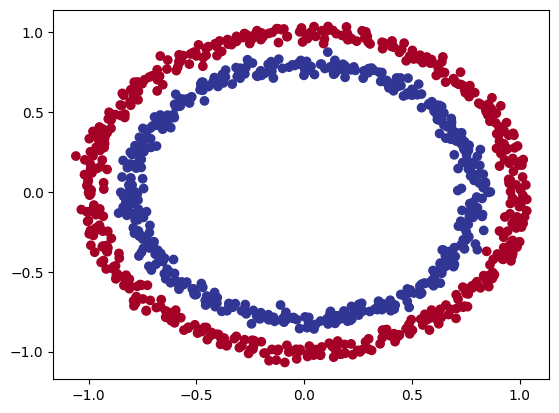

In [ ]:
# Kiểm tra dữ liệu của chúng ta
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

Và xem mô hình đưa ra dự đoán như thế nào trên dữ liệu đó.

313/313 [==============================] - 1s 2ms/step
doing binary classifcation...


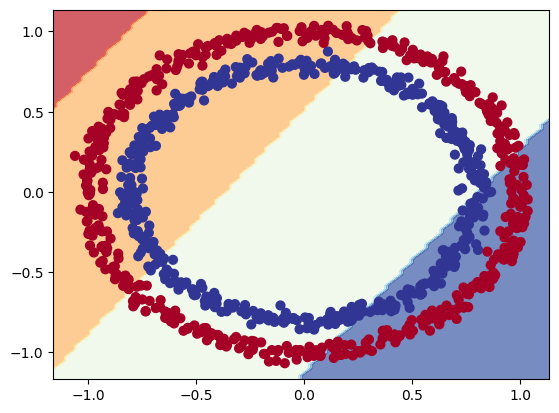

In [ ]:
#Kiểm tra ranh giới quyết định (phần màu xanh là lớp màu xanh, màu vàng là phần giao nhau, màu đỏ là lớp màu đỏ )
plot_decision_boundary(model_4, X, y)

Trông có vẻ như chúng ta lại nhận được một dự đoán đường thẳng (tuyến tính).

Nhưng dữ liệu không tuyến tính (không phải đường thẳng)...

Chúng ta sẽ thêm một số phi tuyến tính vào mô hình.

Hãy sử dụng tham số `activation` ở một trong các lớp để thực hiện điều đó.

In [ ]:
# Thiết lập random seed
tf.random.set_seed(42)

# Tạo mô hình với kích hoạt phi tuyến tính
model_5 = tf.keras.Sequential([
  tf.keras.layers.Dense(1, activation=tf.keras.activations.relu), # cũng có thể đặt activation='relu'
  tf.keras.layers.Dense(1) # lớp đầu ra
])

# Biên dịch mô hình
model_5.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Khớp mô hình
history = model_5.fit(X, y, epochs=100)

Epoch 1/100
32/32 [==============================] - 1s 2ms/step - loss: 4.5403 - accuracy: 0.4870
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 3.7210 - accuracy: 0.4890
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 3.6259 - accuracy: 0.4870
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 3.5609 - accuracy: 0.4840
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 3.5179 - accuracy: 0.4840
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 3.4824 - accuracy: 0.4850
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 3.4535 - accuracy: 0.4860
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 3.4279 - accuracy: 0.4860
Epoch 9/100
32/32 [==============================] - 0s 2ms/step - loss: 3.4058 - accuracy: 0.4870
Epoch 10/100
32/32 [==============================] - 0s 2ms/step - loss: 3.3855 - accuracy: 0.4870
Epoch 11/

Vẫn chưa học được...

Điều gì sẽ xảy ra nếu tăng số lượng nơ-ron và lớp?

Giả sử 2 lớp ẩn với [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu), phát âm là "rel-u", (viết tắt của [rectified linear unit](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/)), kích hoạt ở lớp đầu tiên và 4 nơ-ron mỗi lớp?

Để biết cách nó hoạt động, hãy xem [mô phỏng TensorFlow Playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.001&regularizationRate=0&noise=0&networkShape=4,4&seed=0.93799&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&regularizationRate_hide=true&batchSize_hide=true&dataset_hide=true).

![multi-layer neural net created with TensorFlow playground](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-tensorflow-playground-two-layer-net-relu-activation.png)
*Mạng nơ-ron mà chúng ta sẽ tạo lại với code trong TensorFlow. Xem trực tiếp tại [TensorFlow Playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.001&regularizationRate=0&noise=0&networkShape=4,4&seed=0.93799&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&regularizationRate_hide=true&batchSize_hide=true&dataset_hide=true).*

Hãy thử.

In [ ]:
# Thiết lập random seed
tf.random.set_seed(42)

# Tạo mô hình
model_6 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # lớp ẩn 1, 4 nơ-ron, kích hoạt ReLU
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # lớp ẩn 2, 4 nơ-ron, kích hoạt ReLU
  tf.keras.layers.Dense(1) # lớp đầu ra
])

# Biên dịch mô hình
model_6.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(lr=0.001), # tốc độ học mặc định của Adam là 0.001
                metrics=['accuracy'])

# Khớp mô hình
history = model_6.fit(X, y, epochs=100)

Epoch 1/100
32/32 [==============================] - 1s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 8/100
32/32 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 9/100
32/32 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 10/100
32/32 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 11/

In [ ]:
# Đánh giá mô hình
model_6.evaluate(X, y)

32/32 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.5000


[7.712474346160889, 0.5]

Độ chính xác vẫn là 50%, mô hình vẫn hoạt động như việc đoán.

Các dự đoán trông như thế nào?

313/313 [==============================] - 0s 1ms/step
doing binary classifcation...


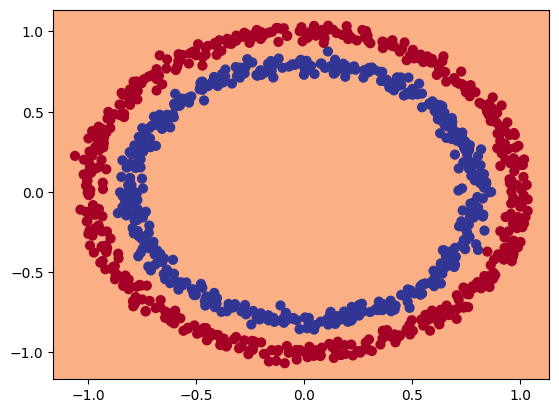

In [ ]:
# Kiểm tra các dự đoán sử dụng 2 lớp ẩn
plot_decision_boundary(model_6, X, y)

Có vấn đề gì vậy?

Có vẻ như mô hình của chúng ta tương tự như mô hình trong [TensorFlow Playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,4&seed=0.93799&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&regularizationRate_hide=true&batchSize_hide=true) nhưng nó vẫn vẽ các đường thẳng...

Lý tưởng nhất là các đường màu vàng nằm bên trong vòng tròn màu đỏ và vòng tròn màu xanh dương.

Hãy lập mô hình đường tròn này lần cuối.

Một mô hình nữa (thực ra chúng ta sẽ xây thêm nhiều mô hình nữa).

Lần này chúng ta sẽ thay đổi hàm kích hoạt, cũng ở lớp đầu ra. Các bạn còn nhớ kiến trúc của mô hình phân loại không? Với phân loại nhị phân, kích hoạt lớp đầu ra thường là [hàm kích hoạt Sigmoid](https://www.tensorflow.org/api_docs/python/tf/math/sigmoid).

In [ ]:
# Thiết lập random seed
tf.random.set_seed(42)

# Tạo mô hình
model_7 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # lớp ẩn 1, kích hoạt ReLU
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # lớp ẩn 2, kích hoạt ReLU
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid) # lớp đầu ra, kích hoạt sigmoid
])

# Biên dịch mô hình
model_7.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Khớp mô hình
history = model_7.fit(X, y, epochs=100, verbose=0)

In [ ]:
# Evaluate our model
model_7.evaluate(X, y)

32/32 [==============================] - 0s 1ms/step - loss: 0.3281 - accuracy: 0.9670


[0.3280692398548126, 0.9670000076293945]

Có vẻ như mô hình đạt được kết quả đáng kinh ngạc, hãy kiểm tra.

313/313 [==============================] - 0s 1ms/step
doing binary classifcation...


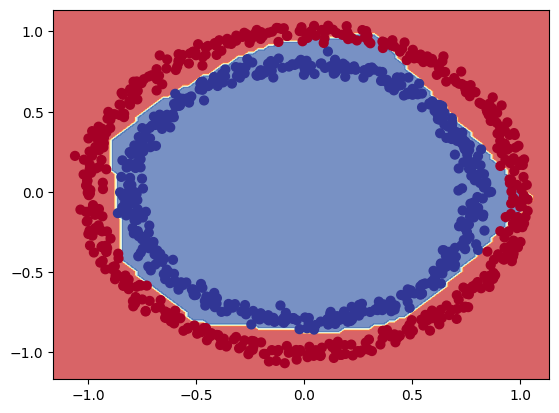

In [ ]:
# Xem các dự đoán của mô hình với kích hoạt relu và sigmoid
plot_decision_boundary(model_7, X, y)

Tuyệt! Có vẻ mô hình gần như hoàn hảo (trừ một số mẫu) phân tách hai đường tròn.

> 🤔 **Câu hỏi:** Có vấn đề gì với những mô hình mà chúng ta tạo ra? Liệu chúng ta có đang thực sự đánh giá chính xác mô hình không? Gợi ý: mô hình học trên dữ liệu nào và chúng ta đã dự đoán điều gì?

Trước khi trả lời, cần nhận ra chúng ta đã đề cập những gì.

> 🔑 **Lưu ý:** Tổ hợp **hàm tuyến tính (đường thẳng) và hàm phi tuyến tính (không phải đường thẳng)** là một trong những thành phần cơ bản quan trọng của mạng nơ-ron.

Hãy nghĩ như sau:

Nếu tôi cho bạn vô số đường thẳng và các đường không thẳng thì bạn có thể vẽ kiểu pattern nào?

Đó cơ bản là những gì mạng nơ-ron thực hiện để tìm pattern trong dữ liệu.

Giờ các bạn có thể nghĩ "nhưng tôi chưa thấy một hàm tuyến tính hoặc hàm phi tuyến tính nào trước đó..."

Có đấy.

Chúng ta sử dụng chúng suốt.

Đó là khả năng của các lớp trong mô hình vừa tạo.

Để nắm roc các hàm kích hoạt mà chúng ta vừa tạo, hãy tạo chúng và thử trên một số dữ liệu giả lập.

In [ ]:
# Tạo một tensor giả lập (giống với dữ liệu mà chúng ta truyền vào mô hình)
A = tf.cast(tf.range(-10, 10), tf.float32)
A

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.],
      dtype=float32)>

Nó trông thế nào?



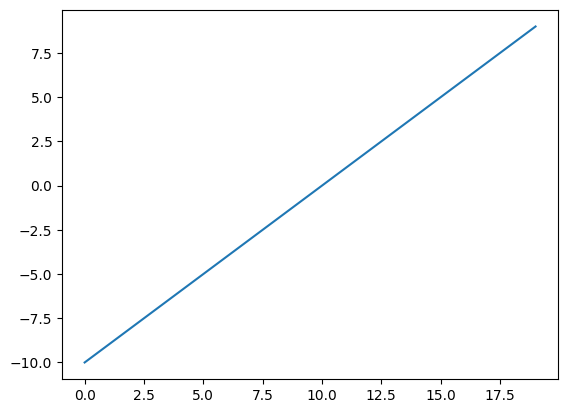

In [ ]:
# Hiển thị tensor giả lập
plt.plot(A);

Một đường thẳng (tuyến tính)!

Hãy tạo lại [hàm sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) và xem nó có tác dụng gì với dữ liệu. Chúng ta cũng có thể tìm một hàm sigmoid đã tạo sẵn ở [`tf.keras.activations.sigmoid`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid).

In [ ]:
# Sigmoid - https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid
def sigmoid(x):
  return 1 / (1 + tf.exp(-x))

# Sử dụng hàm sigmoid trong tensor
sigmoid(A)

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([4.5397872e-05, 1.2339458e-04, 3.3535014e-04, 9.1105117e-04,
       2.4726233e-03, 6.6928510e-03, 1.7986210e-02, 4.7425874e-02,
       1.1920292e-01, 2.6894143e-01, 5.0000000e-01, 7.3105860e-01,
       8.8079703e-01, 9.5257413e-01, 9.8201376e-01, 9.9330717e-01,
       9.9752742e-01, 9.9908900e-01, 9.9966466e-01, 9.9987662e-01],
      dtype=float32)>

Nó trông thế nào?

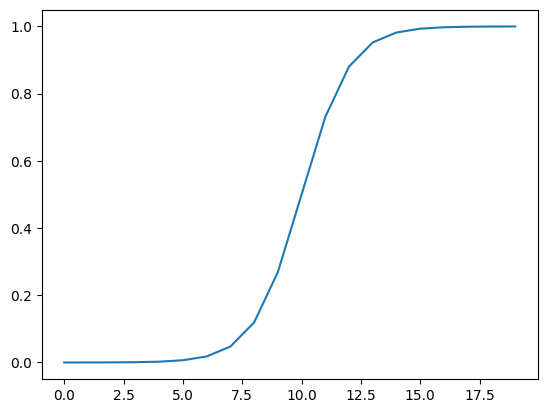

In [ ]:
# Vẽ biểu đồ tensor đã chỉnh sigmoid
plt.plot(sigmoid(A));

Không phải đường thẳng (phi tuyến tính)!

Vậy còn [hàm ReLU function](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/#:~:text=The%20rectified%20linear%20activation%20function,otherwise%2C%20it%20will%20output%20zero.) (ReLU biến tất cả các số âm thành 0 và các số dương vẫn giữ nguyên)?

In [ ]:
# ReLU - https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu
def relu(x):
  return tf.maximum(0, x)

# Truyền tensor giả lập qua hàm ReLU
relu(A)

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6.,
       7., 8., 9.], dtype=float32)>

Tensor đã chỉnh ReLU trông như thế nào?

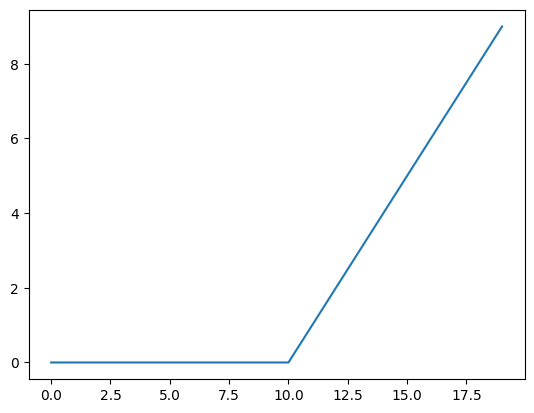

In [ ]:
# Vẽ biểu đồ tensor đã chỉnh ReLU
plt.plot(relu(A));

Một đường không thẳng khác!

Vậy còn [hàm kích hoạt tuyến tính](https://www.tensorflow.org/api_docs/python/tf/keras/activations/linear) của TensorFlow thì sao?

In [ ]:
# Linear - https://www.tensorflow.org/api_docs/python/tf/keras/activations/linear (trả về đầu ra không chỉnh sửa...)
tf.keras.activations.linear(A)

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.],
      dtype=float32)>

Có vẻ đầu ra không bị chỉnh sửa...

In [ ]:
# Kích hoạt tuyến tính có thay đổi gì không?
A == tf.keras.activations.linear(A)

<tf.Tensor: shape=(20,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])>

Có thể hiểu rằng mô hình không thực sự học bất cứ điều gì khi chỉ sử dụng hàm kích hoạt tuyến tính vì hàm kích hoạt tuyến tính không thay đổi bất cứ dữ liệu đầu vào nào.

Trong khi đó với hàm phi tuyến tính, dữ liệu được xử lý. Mạng nơ-ron sử dụng các loại biến đổi này trên quy mô lớn để vẽ các pattern giữa đầu vào và đầu ra của nó.

Bây giờ ngoài việc tìm hiểu sâu về mạng nơ-ron, chúng ta sẽ tiếp tục viết code áp dụng cho những gì chúng ta đã học vào các bài toán khác nhau, nhưng nếu bạn muốn có cái nhìn sâu rộng hơn, hãy xem phần Ngoại khóa bên dưới.

> 📖  **Nguồn:** Tham khảo [machine learning cheatsheet page](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#) để biết thêm về các hàm kích hoạt.

## Đánh giá và cải thiện mô hình phân loại

Nếu trả lời câu hỏi trên, bạn sẽ nhận ra chúng ta sai chỗ nào.

Chúng ta đánh giá mô hình trên cùng một dữ liệu mà nó được huấn luyện.

Phương pháp tốt hơn là tách thành các tập huấn luyện, tập kiểm định (tùy chọn) và tập kiểm tra.

Sau đó, chúng ta sẽ huấn luyện mô hình trên tập huấn luyện (để nó tìm pattern trong dữ liệu) rồi xem nó học các pattern tốt thế nào bằng cách sử dụng nó để dự đoán các giá trị trên tập kiểm tra.

Hãy thực hiện thôi.

In [ ]:
# Có bao nhiêu mẫu trong toàn bộ tập dữ liệu?
len(X)

1000

In [ ]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, y_train = X[:800], y[:800] # 80% dữ liệu cho tập huấn luyện
X_test, y_test = X[800:], y[800:] # 20% dữ liệu cho tập kiểm tra

# Kiểm tra shape của dữ liệu
X_train.shape, X_test.shape # 800 mẫu trong tập huấn luyện, 200 mẫu trong tập kiểm tra

((800, 2), (200, 2))

Chúng ta đã có các tập huấn luyện và tập kiểm tra, hãy lập mô hình dữ liệu huấn luyện và đánh giá xem mô hình học được gì trên tập kiểm tra.

In [ ]:
# Thiết lập random seed
tf.random.set_seed(42)

# Tạo mô hình (tương tự như model_7)
model_8 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation="relu"), # lớp ẩn 1, sử dụng "relu" cho kích hoạt (tương tự như tf.keras.activations.relu)
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid") # lớp đầu ra, sử dụng 'sigmoid' cho đầu ra
])

# Biên dịch mô hình
model_8.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), # tăng tốc độ học từ 0.001 thành 0.01 để học nhanh hơn
                metrics=['accuracy'])

# Khớp mô hình
history = model_8.fit(X_train, y_train, epochs=25)

Epoch 1/25
25/25 [==============================] - 1s 2ms/step - loss: 0.6928 - accuracy: 0.4863
Epoch 2/25
25/25 [==============================] - 0s 2ms/step - loss: 0.6857 - accuracy: 0.5250
Epoch 3/25
25/25 [==============================] - 0s 2ms/step - loss: 0.6797 - accuracy: 0.5387
Epoch 4/25
25/25 [==============================] - 0s 2ms/step - loss: 0.6735 - accuracy: 0.6237
Epoch 5/25
25/25 [==============================] - 0s 2ms/step - loss: 0.6672 - accuracy: 0.5500
Epoch 6/25
25/25 [==============================] - 0s 2ms/step - loss: 0.6580 - accuracy: 0.5838
Epoch 7/25
25/25 [==============================] - 0s 2ms/step - loss: 0.6487 - accuracy: 0.6338
Epoch 8/25
25/25 [==============================] - 0s 2ms/step - loss: 0.6405 - accuracy: 0.6375
Epoch 9/25
25/25 [==============================] - 0s 2ms/step - loss: 0.6290 - accuracy: 0.6500
Epoch 10/25
25/25 [==============================] - 0s 2ms/step - loss: 0.6135 - accuracy: 0.6888
Epoch 11/25
25/25 [

In [ ]:
# Đánh giá mô hình trên tập kiểm tra
loss, accuracy = model_8.evaluate(X_test, y_test)
print(f"Model loss on the test set: {loss}")
print(f"Model accuracy on the test set: {100*accuracy:.2f}%")

7/7 [==============================] - 0s 2ms/step - loss: 0.3008 - accuracy: 0.9100
Model loss on the test set: 0.30081138014793396
Model accuracy on the test set: 91.00%


Độ chính xác 100%!

Khi bắt đầu tạo `model_8`, chúng ta cho rằng nó cũng tương tự `model_7`, tuy nhiên các bạn sẽ thấy điều này không đúng lắm.

Đó là do chúng ta đã thay đổi một số điều:
* **Tham số `activation`** - Chúng ta sử dụng các string (`"relu"` & `"sigmoid"`) thay vì các đường dẫn thư viện (`tf.keras.activations.relu`), cả 2 đều cung cấp chức năng giống nhau trong TensorFlow.
* **Tham số `learning_rate` (hay `lr`)** - Chúng ta tăng tốc độ học trong [Adam optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) từ `0.001` thành `0.01` (tăng 10 lần).
  * Có thể coi tốc độ học là cách mô hình học nhanh thế nào; tốc độ học càng lớn thì mô hình học càng nhanh, tuy nhiên có trường hợp tốc độ học *quá cao*: mô hình cố gắng học quá nhanh và không học được gì cả.
* **Số lượng epoch** - Giảm số lượng epoch (dùng tham số `epochs`) từ 100 xuống còn 20 nhưng mô hình vẫn cho kết quả đáng kinh ngạc trên cả tập huấn luyện và tập kiểm tra.
  * Một trong những lí do mà mô hình hoạt động tốt là vì có ít epoch hơn (nhớ rằng một epoch đơn lẻ tương đương với việc mô hình đang cố học các pattern trong dữ liệu bằng cách nhìn qua nó một lần, nên 25 epoch tức là mô hình có 25 cơ hội) trước đó do chúng ta tăng tốc độ học.

Chúng ta biết mô hình đang thực hiện tốt dựa trên các phép đo đánh giá, hãy xem cách mô hình hoạt động một cách trực quan.


313/313 [==============================] - 0s 1ms/step
doing binary classifcation...
313/313 [==============================] - 0s 1ms/step
doing binary classifcation...


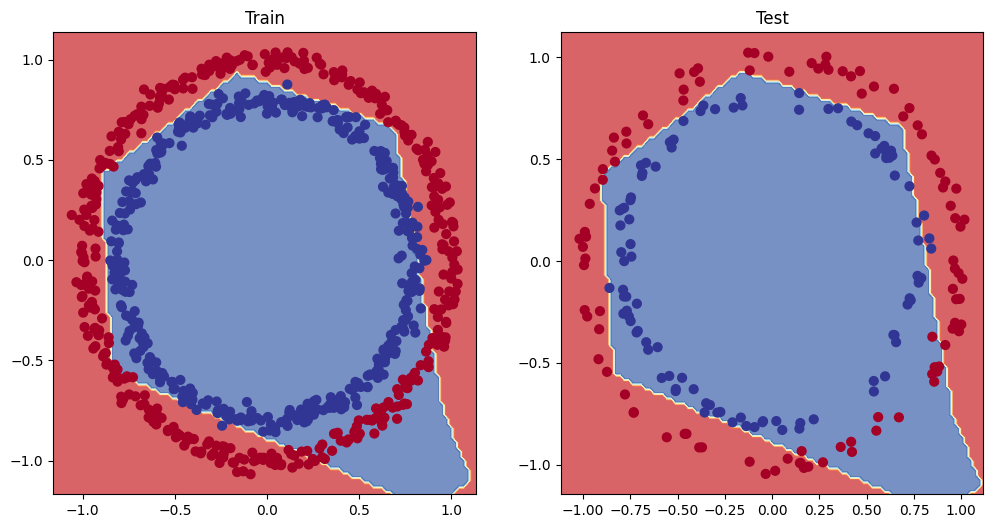

In [ ]:
# Vẽ biểu đồ ranh giới quyết định cho các tập huấn luyện và tập kiểm tra
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_8, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_8, X=X_test, y=y_test)
plt.show()

Tuyệt! Chỉ với một số điều chỉnh, mô hình của chúng ta đang dự đoán các đường tròn màu xanh và đỏ gần như hoàn hảo.

### Vẽ loss curve (đồ thị mất mát)

Quan sát các biểu đồ trên, chúng ta thấy đầu ra của mô hình rất tốt.

Vậy mô hình hoạt động thế nào trong khi nó học?

Chất lượng thay đổi ra sao mỗi lần mô hình có cơ hội xem xét dữ liệu (một lần mỗi epoch)?

Để tìm hiểu điều này, hãy kiểm tra **loss curve (đồ thị mất mát)**

Bạn sẽ thấy chúng ta đang dùng biến `history` khi gọi hàm `fit()` trong mô hình ([`fit()` trả về đối tượng `History`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)).

Đây là nơi chúng ta lấy thông tin về cách mô hình hoạt động thế nào khi nó học.

Hãy xem chúng ta có thể sử dụng nó ra sao.

In [ ]:
# Chúng ta có thể truy cập thông tin trong biến history bằng thuộc tính .history
pd.DataFrame(history.history)

,loss,accuracy
0,0.692831,0.48625
1,0.685712,0.52500
2,0.679661,0.53875
3,0.673490,0.62375
4,0.667202,0.55000
5,0.658027,0.58375
6,0.648721,0.63375
7,0.640455,0.63750
8,0.629043,0.65000
9,0.613540,0.68875


Kiểm tra đầu ra, chúng ta thấy các giá trị loss giảm còn accuracy thì tăng.

Nó trông như thế nào (trực quan hóa)?

Text(0.5, 1.0, 'Model_8 training curves')

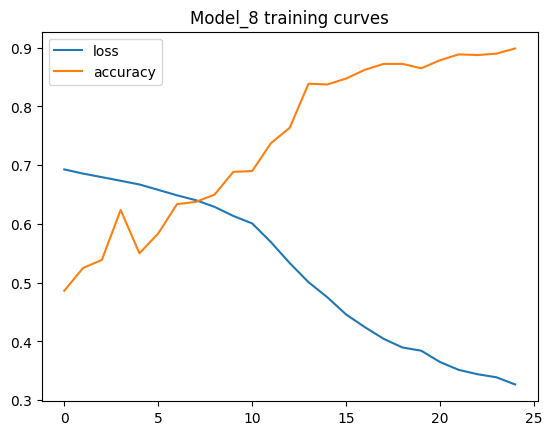

In [ ]:
# Vẽ loss curve
pd.DataFrame(history.history).plot()
plt.title("Model_8 training curves")

Rất tốt! Đây là đồ thị lý tưởng mà chúng ta đang tìm kiếm để giải bài toán phân loại, giảm mất mát và tăng độ chính xác.

> 🔑 **Lưu ý:** Với nhiều bài toán, hàm mất mát giảm tức là mô hình đang cải thiện (dự đoán mà mô hình đưa ra đang tiến gần hơn tới nhãn gốc).

### Tìm tốc độ học tốt nhất

Ngoài kiến trúc (các lớp, số nơ-ron, kích hoạt,...), siêu tham số quan trọng nhất mà chúng ta có thể điều chỉnh cho mô hình mạng nơ-ron là **tốc độ học**.

Các bạn thấy trong `model_8`, chúng ta đã giảm tốc độ học của thuật toán tối ưu Adam từ `0.001` (mặc định) xuống còn `0.01`.

Có thể mọi người sẽ thắc mắc tại sao chúng ta làm vậy.

Theo cách này, nó là một dự đoán may mắn.

Tôi vừa quyết định giảm tốc độ học và xem mô hình hoạt động như thế nào.

Có thể các bạn đang nghĩ "Thật à? Bạn có thể làm vậy sao?

Đáp án là có. Chúng ta có thể thay đổi bất kì siêu tham số nào của mạng nơ-ron"

Để thực hành, hãy bắt đầu xem những siêu tham số nào hoạt động và không hoạt động.

Chúng ta cần hiểu ML và DL nói chung. Điều này cần thực nghiệm rất nhiều: cứ lặp lại việc xây một mô hình và đánh giá.

Tôi muốn đề xuất một thủ thuật giúp chúng ta tìm ra tốc độ học tốt nhất (ít nhất là để bắt đầu huấn luyện) cho mô hình.

Để thực hiện, chúng ta sẽ dùng:
* [Learning rate **callback**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler).
   * Các bạn có thể coi callback như một phần chức năng bổ sung có thể thêm vào mô hình *trong khi* huấn luyện.
* Một mô hình khác (chúng ta có thể sử dụng các mô hình tương tự như trên, ở đây chúng ta đang luyện tập xây dựng mô hình).
* Loss curve đã chỉnh sửa.

Hãy xem xét từng ý kèm code rồi diễn giải những điều đang diễn ra.

> 🔑 **Lưu ý:** Siêu tham số mặc định của các thành phần cơ bản của mạng nơ-ron trong TensorFlow được thiết lập để hoạt động ngay được (ví dụ: thiết lập [thuật toán tối ưu Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) mặc định thường đạt được kết quả tốt trên nhiều tập dữ liệu. Do đó, hãy thử các siêu tham số mặc định trước, rồi điều chỉnh nếu cần.

In [ ]:
# Thiết lập random seed
tf.random.set_seed(42)

# Tạo mô hình (tương tự như model_8)
model_9 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

# Biên dịch mô hình
model_9.compile(loss="binary_crossentropy", # chúng ta cũng có thể sử dụng string ở đây
              optimizer="Adam", # tương tự như tf.keras.optimizers.Adam() với các thiết lập mặc định
              metrics=["accuracy"])

# Tạo learning rate scheduler callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20)) # xem xét một tập hợp các giá trị tốc độ học từ 1e-4, tăng 10**(epoch/20) mỗi epoch

# Khớp mô hình (truyền lr_scheduler callback)
history = model_9.fit(X_train,
                      y_train,
                      epochs=100,
                      callbacks=[lr_scheduler])

Epoch 1/100
25/25 [==============================] - 1s 3ms/step - loss: 0.6898 - accuracy: 0.5113 - lr: 1.0000e-04
Epoch 2/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6897 - accuracy: 0.5088 - lr: 1.1220e-04
Epoch 3/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6895 - accuracy: 0.5088 - lr: 1.2589e-04
Epoch 4/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6893 - accuracy: 0.5075 - lr: 1.4125e-04
Epoch 5/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6891 - accuracy: 0.5088 - lr: 1.5849e-04
Epoch 6/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6889 - accuracy: 0.5113 - lr: 1.7783e-04
Epoch 7/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6886 - accuracy: 0.5063 - lr: 1.9953e-04
Epoch 8/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6884 - accuracy: 0.5063 - lr: 2.2387e-04
Epoch 9/100
25/25 [==============================] - 0s 3ms/step - loss:

Mô hình đã hoàn thành huấn luyện, hãy xem lịch sử huấn luyện.

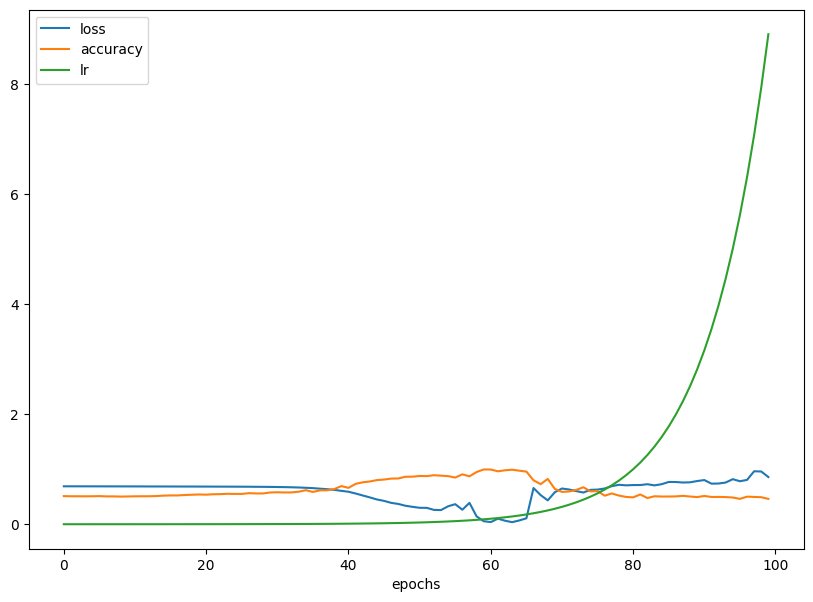

In [ ]:
# Kiểm tra lịch sử
pd.DataFrame(history.history).plot(figsize=(10,7), xlabel="epochs");

Các bạn sẽ thấy tốc độ học tăng theo cấp số nhân khi tăng số lượng epoch.

Và độ chính xác của mô hình cũng tăng (mất mát giảm) ở một điểm nhất định khi tốc độ học tăng dần.

Để tìm điểm ra điểm uốn này, hãy vẽ biểu đồ loss với learning rate theo thang log.

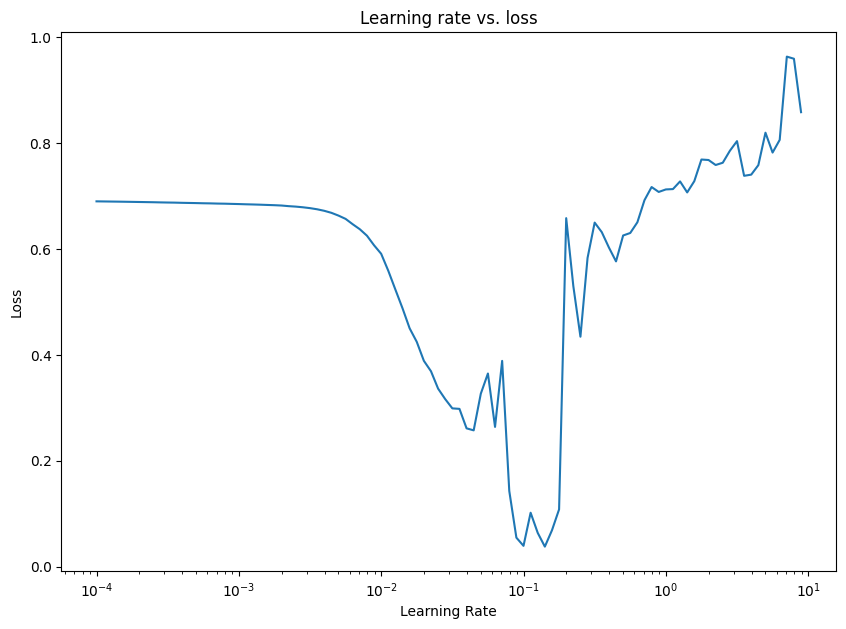

In [ ]:
# Vẽ biểu đồ learning rate với loss
lrs = 1e-4 * (10 ** (np.arange(100)/20))
plt.figure(figsize=(10, 7))
plt.semilogx(lrs, history.history["loss"]) # muốn trục x (learning rate) theo thang log
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning rate vs. loss");

Để tìm giá trị tốc độ học lý tưởng (ít nhất là giá trị lý tưởng để *bắt đầu* huấn luyện mô hình), chúng ta sẽ sử dụng quy tắc ngón tay cái: lấy giá trị learning rate mà loss vẫn đang giảm nhưng không quá phẳng (thường nhỏ hơn 10 lần so với đáy của đường cong).

Trong trường hợp này, tốc độ học lý tưởng kết thúc trong khoảng `0.01` ($10^{-2}$) và `0.02`.

![finding the ideal learning rate by plotting learning rate vs. loss](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-learning-rate-vs-loss.png)

*Tốc độ học lý tưởng khi bắt đầu huấn luyện mô hình ở đâu đó ngay trước khi đường cong loss chạm đáy (giá trị mà loss vẫn đang giảm).*  

In [ ]:
# Ví dụ về giá trị tốc độ học điển hình khác
10**0, 10**-1, 10**-2, 10**-3, 1e-4

(1, 0.1, 0.01, 0.001, 0.0001)

Chúng ta đã ước tính tốc độ học lý tưởng (dùng `0.02`) cho mô hình, hãy khớp lại nó.

In [ ]:
# Thiết lập random seed
tf.random.set_seed(42)

# Tạo mô hình
model_10 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

# Biên dịch mô hình với tốc độ học lý tưởng
model_10.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.02), # sử dụng tf.keras.optimizers.Adam (không phải "adam") để điều chỉnh tốc độ học
                metrics=["accuracy"])

# Khớp mô hình cho 20 epoch (ít hơn trước 5)
history = model_10.fit(X_train, y_train, epochs=20)

Epoch 1/20
25/25 [==============================] - 1s 2ms/step - loss: 0.6849 - accuracy: 0.5650
Epoch 2/20
25/25 [==============================] - 0s 2ms/step - loss: 0.6735 - accuracy: 0.5587
Epoch 3/20
25/25 [==============================] - 0s 2ms/step - loss: 0.6484 - accuracy: 0.6363
Epoch 4/20
25/25 [==============================] - 0s 3ms/step - loss: 0.6038 - accuracy: 0.7225
Epoch 5/20
25/25 [==============================] - 0s 2ms/step - loss: 0.5532 - accuracy: 0.7525
Epoch 6/20
25/25 [==============================] - 0s 2ms/step - loss: 0.4980 - accuracy: 0.8025
Epoch 7/20
25/25 [==============================] - 0s 2ms/step - loss: 0.4543 - accuracy: 0.8300
Epoch 8/20
25/25 [==============================] - 0s 2ms/step - loss: 0.4206 - accuracy: 0.8350
Epoch 9/20
25/25 [==============================] - 0s 3ms/step - loss: 0.3959 - accuracy: 0.8637
Epoch 10/20
25/25 [==============================] - 0s 3ms/step - loss: 0.3673 - accuracy: 0.8750
Epoch 11/20
25/25 [

Tuyệt! Chúng ta đạt được độ chính xác cao hơn `model_8` với tốc độ học cao hơn một chút và ít epoch hơn ((`20` thay vì `25`).

> 🛠 **Thực hành:** Các bạn đã thấy ví dụ về những điều có thể xảy ra khi thay đổi tốc độ học, hãy thử thay đổi giá trị tốc độ học trong [TensorFlow Playground](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.03154&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&regularizationRate_hide=true&problem_hide=true) và xem điều gì sẽ xảy ra. Sẽ thế nào nếu chúng ta tăng hoặc giảm tốc độ học?



In [ ]:
# Đánh giá mô hình trên tập dữ liệu kiểm tra
model_10.evaluate(X_test, y_test)

7/7 [==============================] - 0s 3ms/step - loss: 0.2000 - accuracy: 0.9500


[0.19997245073318481, 0.949999988079071]

Hãy xem các dự đoán trông như thế nào.

313/313 [==============================] - 1s 2ms/step
doing binary classifcation...
313/313 [==============================] - 0s 1ms/step
doing binary classifcation...


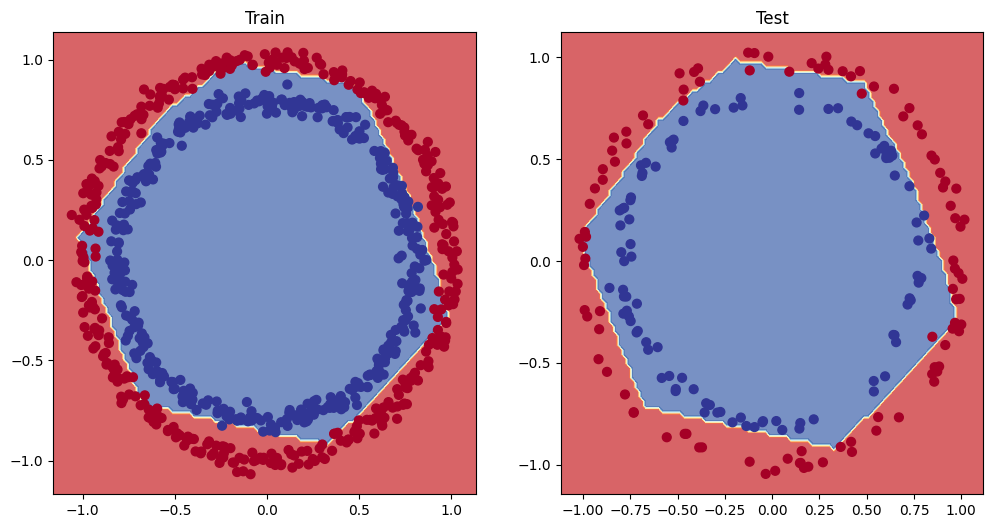

In [ ]:
# Vẽ biểu đồ ranh giới quyết định cho tập huấn luyện và tập kiểm tra
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_10, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_10, X=X_test, y=y_test)
plt.show()

Như các bạn thấy, chúng gần như hoàn hảo.

Đây là những loại thử nghiệm mà chúng ta sẽ thường chạy khi xây dựng mô hình của mình.

Hãy bắt đầu với các thiết lập mặc định và xem chúng hoạt động thế nào trên dữ liệu.

Nếu chúng không hoạt động như mong muốn, hãy cải thiện thêm.

Hãy xem thêm một số cách đánh giá mô hình phân loại.

### Các phương pháp đánh giá phân loại

Ngoài trực quan hóa, chúng ta có thể sử dụng nhiều phép đo đánh giá khác để đánh giá mô hình phân loại.

| **Tên phép đo/Phương pháp đánh giá** | **Định nghĩa** | **Code** |
| --- | --- | --- |
| Accuracy | Trong 100 dự đoán, mô hình đoán đúng bao nhiêu? Ví dụ: accuracy = 95% tức là mô hình đoán đúng 95/100. | [`sklearn.metrics.accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) hoặc [`tf.keras.metrics.Accuracy()`](tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy) |
| Precision | Tỷ lệ true positive trên tổng số mẫu. Precision cao hơn sẽ ít false positiive hơn (mô hình đoán 1 trong khi nó đáng lẽ là 0). | [`sklearn.metrics.precision_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) hoặc [`tf.keras.metrics.Precision()`](tensorflow.org/api_docs/python/tf/keras/metrics/Precision) |
| Recall | Tỷ lệ true positive trên tổng của true positive và false negative (mô hình đoán 0 trong khi nó đáng lẽ là 1). Recall cao hơn sẽ ít false negative hơn. | [`sklearn.metrics.recall_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) hoặc [`tf.keras.metrics.Recall()`](tensorflow.org/api_docs/python/tf/keras/metrics/Recall) |
| F1-score | Kết hợp precision và recall thành một phép đo. 1 là tốt nhất, 0 là kém nhất. | [`sklearn.metrics.f1_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) |
| [Confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)  | So sánh các giá trị dự đoán với giá trị thực theo bảng, nếu đúng 100% thì tất cả giá trị trong ma trận sẽ nằm ở trên cùng bên trái tới dưới cùng bên phải (đường chéo). | Custom function hoặc [`sklearn.metrics.plot_confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html) |
| Classification report | Tập hợp một số phép đo phân loại chính như precision, recall và f1-score. | [`sklearn.metrics.classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) |

> 🔑 **Lưu ý:** Mỗi bài toán phân loại sẽ yêu cầu các kiểu phương pháp đánh giá khác nhau. Nhưng ít nhất các bạn nên làm quen với các phương pháp trên.

Hãy bắt đầu với accuracy.

 Do chúng ta truyền `["accuracy"]` vào tham số `metrics` khi biên dịch mô hình nên hãy gọi `evaluate()` để nó trả về loss và accuracy.

In [ ]:
# Kiểm tra độ chính xác của mô hình
loss, accuracy = model_10.evaluate(X_test, y_test)
print(f"Model loss on test set: {loss}")
print(f"Model accuracy on test set: {(accuracy*100):.2f}%")

7/7 [==============================] - 0s 2ms/step - loss: 0.2000 - accuracy: 0.9500
Model loss on test set: 0.19997245073318481
Model accuracy on test set: 95.00%


Vậy còn confusion matrix (ma trận nhầm lẫn)?

![anatomy of a confusion matrix](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-anatomy-of-a-confusion-matrix.png)
*Phân tích ma trận nhầm lẫn (những gì chúng ta sẽ tạo). Các dự đoán đúng xuất hiện theo đường chéo (từ trên cùng bên trái xuống dưới cùng bên phải).*

Chúng ta có thể tạo ma trận nhầm lẫn sử dụng phương thức  [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) của Scikit-learn.

In [ ]:
# Tạo confusion matrix
from sklearn.metrics import confusion_matrix

# Đưa ra dự đoán
y_preds = model_10.predict(X_test)
y_preds_threshold = (y_preds>=0.5).astype(int)
# Tạo confusion matrix
confusion_matrix(y_test, y_preds_threshold)

7/7 [==============================] - 0s 2ms/step


array([[91, 10],
       [ 0, 99]])

In [ ]:
y_test

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0])

Có vẻ như các dự đoán không ở định dạng mà chúng ta cần.

Hãy kiểm tra.

In [ ]:
# Xem 10 dự đoán đầu tiên
y_preds[:10]

array([[0.79901206],
       [0.86971927],
       [0.86971927],
       [0.86971927],
       [0.7152207 ],
       [0.6962384 ],
       [0.8511426 ],
       [0.12417743],
       [0.84842896],
       [0.00498754]], dtype=float32)

Vậy còn các nhãn kiểm tra?

In [ ]:
# Xem 10 nhãn kiểm tra đầu tiên
y_test[:10]

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0])

Có vẻ như chúng ta cần biến các dự đoán thành định dạng nhị phân (0 hoặc 1).

Chắc các bạn đang thắc mắc định dạng hiện tại là gì?

Ở định dạng hiện tại (`9.8526537e-01`), chúng ở dạng **xác suất dự đoán**.

Các bạn sẽ thấy điều này thường xuyên với đầu ra của mạng nơ-ron. Chúng thường không phải các giá trị chính xác nhưng nhiều *khả năng* là giá trị này hoặc giá trị khác.

Một trong các bước mà các bạn thường thấy sau khi đưa ra dự đoán với mạng nơ-ron là chuyển xác suất dự đoán thành nhãn.

Trong trường hợp của chúng ta, do nhãn gốc (`y_test`) là các số nhị phân (0 hoặc 1) nên chúng ta có thể chuyển đổi xác suất dự đoán thành dạng nhị phân bằng [`tf.round()`](https://www.tensorflow.org/api_docs/python/tf/math/round).

In [ ]:
# Chuyển xác suất dự đoán sang dạng nhị phân và xem 10 dự đoán đầu tiên
tf.round(y_preds)[:10]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.]], dtype=float32)>

Tuyệt vời! Bây giờ chúng ta có thể sử dụng hàm `confusion_matrix`.

In [ ]:
# Tạo confusion matrix
confusion_matrix(y_test, tf.round(y_preds))

array([[91, 10],
       [ 0, 99]])

Chúng ta thấy những số lớn nhất nằm dọc theo đường chéo (từ trên cùng bên trái xuống dưới cùng bên phải) nên đây là một dấu hiệu tốt, nhưng phần còn lại của ma trận không thực sự tiết lộ nhiều điều.

Vậy chúng ta có nên tạo hàm để giúp confusion matrix trực quan hơn một chút không?

In [ ]:
import itertools

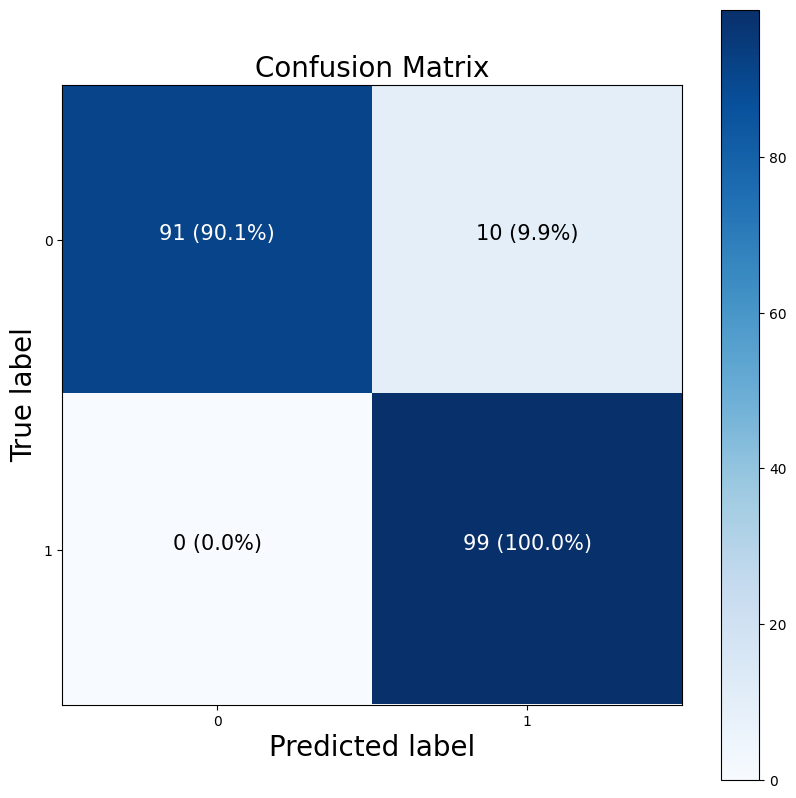

In [ ]:
# Lưu ý: Code sau cho confusion matrix là bản phối lại của Scikit-Learn giữa
# hàm plot_confusion_matrix - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
# và notebook giới thiệu của Made with ML - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb

figsize = (10, 10)

# Tạo confusion matrix
cm = confusion_matrix(y_test, tf.round(y_preds))
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
n_classes = cm.shape[0]

# Hãy tô điểm nó
fig, ax = plt.subplots(figsize=figsize)
# Tạo biểu đồ ma trận
cax = ax.matshow(cm, cmap=plt.cm.Blues) # https://matplotlib.org/3.2.0/api/_as_gen/matplotlib.axes.Axes.matshow.html
fig.colorbar(cax)

# Tạo classes
classes = False

if classes:
  labels = classes
else:
  labels = np.arange(cm.shape[0])

# Dán nhãn các trục
ax.set(title="Confusion Matrix",
       xlabel="Predicted label",
       ylabel="True label",
       xticks=np.arange(n_classes),
       yticks=np.arange(n_classes),
       xticklabels=labels,
       yticklabels=labels)

# Đặt nhãn trục x thành bottom
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()

# Điều chỉnh size của nhãn
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(20)

# Thiết lập ngưỡng cho các màu khác nhau
threshold = (cm.max() + cm.min()) / 2.

# Lập biểu đồ văn bản ở từng cell
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
           horizontalalignment="center",
           color="white" if cm[i, j] > threshold else "black",
           size=15)

Trông tốt hơn nhiều rồi. Có vẻ như mô hình đã đưa ra các dự đoán gần như hoàn hảo trên tập kiểm tra, ngoại trừ 2 false positive (góc trên cùng bên phải).

In [ ]:
# itertools.product có tác dụng gì? Kết hợp 2 thứ vào mỗi tổ hợp
import itertools
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  print(i, j)

0 0
0 1
1 0
1 1


## Làm việc với mẫu lớn (phân loại đa lớp)

Chúng ta đã thấy mẫu phân loại đa lớp nhị phân (dự đoán xem một điểm dữ liệu có thuộc về đường tròn đỏ hoặc xanh không), tuy nhiên nếu có nhiều lớp khác nhau thì sao?

Ví dụ: giả sử bạn là một công ty thời trang và cần xây dựng một mạng nơ-ron để dự đoán xem một mảnh vải là của giày, áo sơ mi hay áo khoác (3 lựa chọn khác nhau).

Khi lựa chọn có nhiều hơn 2 lớp thì đây là **multiclass classification (phân loại đa lớp)**.

Điều tốt là những thứ mà chúng ta học được cho tới giờ (với một số điều chỉnh) có thể áp dụng cho các bài toán phân loại đa lớp.

Hãy xem triển khai của điều này.

Để bắt đầu, chúng ta cần một số dữ liệu. Tin tốt là TensorFlow có một tập dữ liệu phân loại đa lớp có sẵn là [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist), chúng ta có thể bắt đầu ngay lập tức.

Import nó bằng module [`tf.keras.datasets`](https://www.tensorflow.org/api_docs/python/tf/keras/datasets).

> 📖 **Nguồn:** Bài toán phân loại đa lớp sau được lấy từ [TensorFlow classification guide](https://www.tensorflow.org/tutorials/keras/classification). Nên đi qua các ví dụ rồi lặp lại hướng dẫn của TensorFlow.

In [20]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

# Dữ liệu đã được sắp xếp thành tập huấn luyện và tập kiểm tra
(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


Hãy xem một ví dụ.

In [ ]:
# Hiển thị mẫu huấn luyện đầu tiên
print(f"Training sample:\n{train_data[0]}\n")
print(f"Training label: {train_labels[0]}")

Training sample:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1  

Chúng ta nhận được một danh sách khá dài có các số, theo sau (dữ liệu) là một số duy nhất (class label).

Vậy còn shape?

In [ ]:
# Kiểm tra shape của dữ liệu
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [ ]:
#Kiểm tra shape của một mẫu đơn lẻ
train_data[0].shape, train_labels[0].shape

((28, 28), ())

60,000 mẫu huấn luyện, mỗi mẫu có shape (28, 28) và một nhãn cũng như 10,000 mẫu kiểm tra, mỗi mẫu có shape (28, 28)

Nhưng đó chỉ là các số, hãy trực quan hóa chúng.

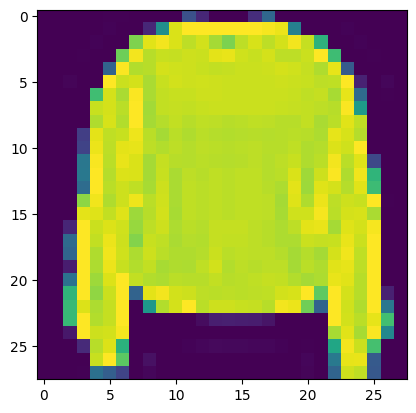

In [21]:
# Lập biểu đồ một mẫu duy nhất
import matplotlib.pyplot as plt
plt.imshow(train_data[7]);

Vậy còn nhãn của nó thì sao?

In [ ]:
# Kiểm tra các nhãn mẫu
train_labels[7]

2

Có vẻ các nhãn của chúng ta ở dạng số. Dù điều này tốt với mạng nơ-ron, chúng ta vẫn cần nhãn ở dạng con người đọc được.

Hãy tạo một danh sách nhỏ gồm tên các lớp (chúng ta có thể tìm thấy trong tập dữ liệu của [GitHub](https://github.com/zalandoresearch/fashion-mnist#labels) ).

> 🔑 **Lưu ý:** Mặc dù tập dữ liệu này đã được chuẩn bị và sẵn sàng hoạt động, cần nhớ rằng nhiều tập dữ liệu sẽ không như vậy. Các bạn thường sẽ phải thực hiện một số bước tiền xử lý để nó sẵn sàng sử dụng với mạng nơ-ron (chúng ta sẽ thấy nhiều hơn khi thực hiện với dữ liệu sau này).

In [22]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Có bao nhiêu lớp (đây sẽ là shape đầu ra)?
len(class_names)

10

Hãy lập biểu đồ một mẫu khác.

> 🤔 **Câu hỏi:** Hãy đặc biệt chú ý xem dữ liệu mà chúng ta đang thực hiện *trông* như thế nào? Nó có phải chỉ là đường thẳng hay không phải đường thẳng? Các bạn có nghĩ rằng nếu chúng ta cần tìm pattern trong các bức hình về trang phục (thực ra là tập hợp các điểm ảnh) thì mô hình có cần phi tuyến tính (không phải đường thẳng) hay không?

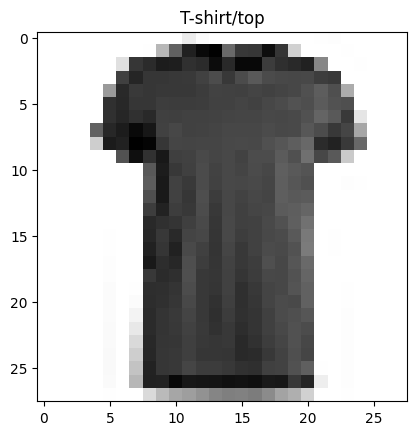

In [ ]:
# Vẽ biểu đồ ảnh mẫu và nhãn của nó
plt.imshow(train_data[17], cmap=plt.cm.binary) # thay đổi màu sắc thành đen và trắng
plt.title(class_names[train_labels[17]]);

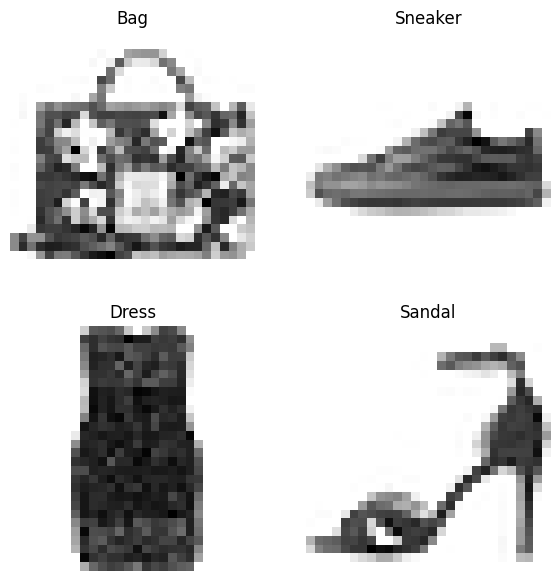

In [ ]:
# Vẽ biểu đồ nhiều hình của fashion MNIST
import random
plt.figure(figsize=(7, 7))
for i in range(4):
  ax = plt.subplot(2, 2, i + 1)
  rand_index = random.choice(range(len(train_data)))
  plt.imshow(train_data[rand_index], cmap=plt.cm.binary)
  plt.title(class_names[train_labels[rand_index]])
  plt.axis(False)

Hãy xây dựng mô hình để tìm mối quan hệ giữa các giá trị điểm ảnh và nhãn của chúng.

Vì đây là bài toán phân loại nên chúng ta sẽ thay đổi một ít kiến trúc (trực tiếp với Bảng 1 ở trên):

* **Input shape** sẽ phải xử lý tensor 28x28 (chiều cao và rộng của ảnh).
  * Thực ra chúng ta sẽ nén đầu vào thành một tensor (vectơ) có shape `(784)`.
* **Output shape** sẽ phải là 10 vì chúng ta cần mô hình dự đoán cho 10 lớp khác nhau.
  * Chúng ta cũng sẽ thay đổi tham số `activation` của lớp đầu ra thành [`"softmax"`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) thay vì `'sigmoid'`. Hàm kích hoạt `"softmax"` sẽ xuất ra một chuỗi các giá trị trong khoảng từ 0 tới 1 (có shape tương tự như **output shape**, cộng lại thành ~1). Chỉ mục có giá trị cao nhất mà mô hình dự đoán *rất có thể* là lớp.
* Chúng ta cần thay đổi hàm mất mát từ hàm mất mát nhị phân thành hàm mất mát đa lớp.
  * Cụ thể, chúng ta sẽ dùng [`tf.keras.losses.SparseCategoricalCrossentropy()`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) nếu các nhãn ở dạng số nguyên, dùng [`tf.keras.losses.CategoricalCrossentropy()`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) nếu các nhãn được mã hóa one-hot.
* Chúng ta cũng sẽ sử dụng tham số `validation_data` khi gọi hàm `fit()`, điều này cho biết cách mô hình hoạt động trên tập kiểm tra trong suốt quá trình huấn luyện.

Hãy thử thôi.

In [ ]:
# Thiết lập random seed
tf.random.set_seed(42)

# Tạo mô hình
model_11 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)), # lớp đầu vào (cần reshape 28x28 thành 784, lớp Flatten sẽ thực hiện điều này cho chúng ta)
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(10, activation="softmax") # output shape là 10, activation là softmax
])

# Biên dịch mô hình
model_11.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), # hàm mất mát khác nhau cho phân loại đa lớp
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

# Khớp mô hình
non_norm_history = model_11.fit(train_data,
                                train_labels,
                                epochs=10,
                                validation_data=(test_data, test_labels)) # xem mô hình hoạt động như thế nào trên tập kiểm tra trong quá trình huấn luyện

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.1442 - accuracy: 0.5520 - val_loss: 0.7739 - val_accuracy: 0.7139
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.7147 - accuracy: 0.7401 - val_loss: 0.7201 - val_accuracy: 0.7432
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6607 - accuracy: 0.7668 - val_loss: 0.6612 - val_accuracy: 0.7649
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6352 - accuracy: 0.7786 - val_loss: 0.6506 - val_accuracy: 0.7731
Epoch 5/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.6211 - accuracy: 0.7827 - val_loss: 0.6364 - val_accuracy: 0.7731
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6074 - accuracy: 0.7890 - val_loss: 0.6311 - val_accuracy: 0.7813
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5989 - accuracy: 0.7922 - val_loss: 0.6294 - val_accuracy:

In [ ]:
# Kiểm tra shape của mô hình
# Lưu ý: "None" trong (None, 784) là batch_size, chúng ta sẽ đề cập nó sau
model_11.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_28 (Dense)            (None, 4)                 3140      
                                                                 
 dense_29 (Dense)            (None, 4)                 20        
                                                                 
 dense_30 (Dense)            (None, 10)                50        
                                                                 
Total params: 3210 (12.54 KB)
Trainable params: 3210 (12.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Mô hình đạt được độ chính xác ~35% sau 10 epoch, sử dụng mô hình có phong cách tương tự như mô hình mà chúng ta dùng cho bài toán phân loại nhị phân, điều này tốt hơn so với việc đoán (đoán 10 lớp được độ chính xác 10%), nhưng chúng ta có thể làm tốt hơn thế.

Các bạn còn nhớ khi chúng ta nhắc tới mạng nơ-ron ưu tiên các số trong khoảng từ 0 tới 1 không? (nếu không, hãy coi đây là một lời nhắc)

Bây giờ dữ liệu mà chúng ta có không trong khoảng 0-1, nói cách khác, nó không được chuẩn hóa (nên chúng ta dùng biến `non_norm_history` khi gọi `fit()`). Nó là giá trị điểm ảnh trong khoảng 0-255.

Hãy xem.

In [ ]:
# Kiểm tra các giá trị nhỏ nhất, lớn nhất của dữ liệu huấn luyện
train_data.min(), train_data.max()

(0, 255)

Chúng ta thu được các giá trị từ 0 tới 1 bằng cách chia toàn bộ mảng cho giá trị lớn nhất: `255.0`(chia cho float cũng chuyển thành float).


Làm như vậy sẽ khiến toàn bộ dữ liệu nằm trong khoảng 0-1 (gọi là **co giãn (scaling)** hoặc **chuẩn hóa (normalization)**).

In [25]:
# Chia các hình ảnh huấn luyện và kiểm tra cho giá trị lớn nhất (chuẩn hóa nó)
train_data = train_data / 255.0
test_data = test_data / 255.0

# Kiểm tra các giá trị lớn nhất và nhỏ nhất của dữ liệu huấn luyện
train_data.min(), train_data.max()

(0.0, 1.0)

Tuyệt! Giờ dữ liệu đã nằm trong khoảng 0-1. Hãy xem điều gì sẽ xảy ra nếu chúng ta mô hình hóa nó.

Chúng ta sẽ sử dụng mô hình tương tự như trước (`model_11`) trừ việc lần này dữ liệu được chuẩn hóa.

In [ ]:
# Thiết lập random seed
tf.random.set_seed(42)

# Tạo mô hình
model_12 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)), # lớp đầu vào (cần reshape 28x28 thành 784)
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(10, activation="softmax") # output shape là 10, activation là softmax
])

# Biên dịch mô hình
model_12.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

# Khớp mô hình (với dữ liệu đã chuẩn hóa)
norm_history = model_12.fit(train_data,
                            train_labels,
                            epochs=10,
                            validation_data=(test_data, test_labels))

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 1.2346 - accuracy: 0.5175 - val_loss: 0.7514 - val_accuracy: 0.7415
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6844 - accuracy: 0.7588 - val_loss: 0.6695 - val_accuracy: 0.7690
Epoch 3/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.6283 - accuracy: 0.7813 - val_loss: 0.6442 - val_accuracy: 0.7727
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6008 - accuracy: 0.7933 - val_loss: 0.6122 - val_accuracy: 0.7905
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5861 - accuracy: 0.7976 - val_loss: 0.6027 - val_accuracy: 0.7946
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5735 - accuracy: 0.8015 - val_loss: 0.6091 - val_accuracy: 0.7920
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5641 - accuracy: 0.8055 - val_loss: 0.6187 - val_accuracy:

Cùng một mô hình như trước nhưng lần này, mô hình với dữ liệu đã chuẩn hóa cho độ chính xác cao hơn nhiều!

Lập biểu đồ lịch sử của từng mô hình (loss curve)

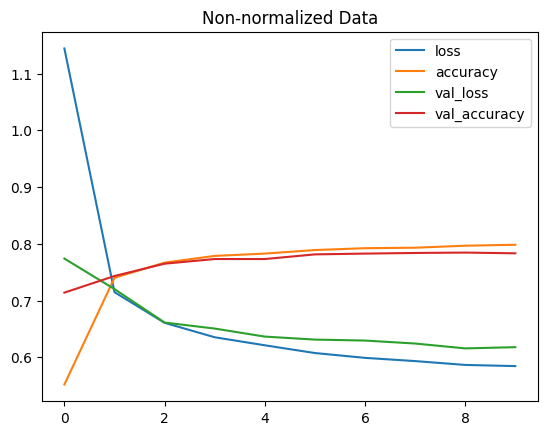

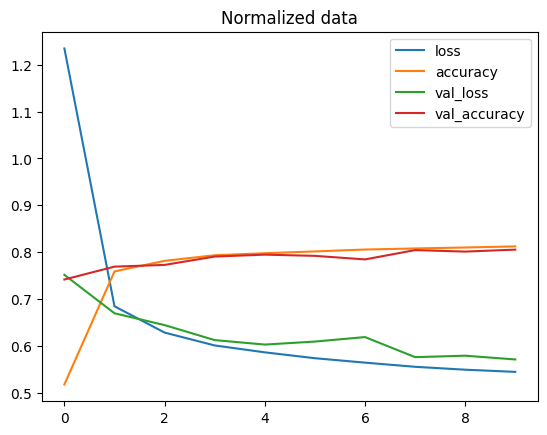

In [ ]:
import pandas as pd
# Vẽ biểu đồ loss curve của dữ liệu không được chuẩn hóa
pd.DataFrame(non_norm_history.history).plot(title="Non-normalized Data")
# Vẽ biểu đồ loss curve của dữ liệu đã được chuẩn hóa
pd.DataFrame(norm_history.history).plot(title="Normalized data");

Từ 2 biểu đồ trên, chúng ta thấy rằng mô hình với dữ liệu đã chuẩn hóa (`model_12`) cải thiện nhanh hơn so với mô hình không có dữ liệu được chuẩn hóa (`model_11`).

> 🔑 **Lưu ý:** Cùng một mô hình nhưng dữ liệu khác *một chút* cũng dẫn tới các kết quả khác biệt *đáng kể*. Do đó, khi so sánh các mô hình, cần đảm bảo so sánh trên cùng tiêu chí (ví dụ: kiến trúc giống nhau nhưng dữ liệu khác nhau hoặc dữ liệu giống nhau nhưng kiến trúc khác nhau).

Hãy tìm tốc độ học tốt nhất và xem điều gì xảy ra?

Chúng ta sẽ dùng cũng một kiến trúc đang được sử dụng.

In [ ]:
# Thiết lập random seed
tf.random.set_seed(42)

# Tạo mô hình
model_13 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)), # lớp đầu vào (cần reshape 28x28 thành 784)
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(10, activation="softmax") # output shape là 10, activation là softmax
])

# Biên dịch mô hình
model_13.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

# Tạo learning rate callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch/20))

# Khớp mô hình
find_lr_history = model_13.fit(train_data,
                               train_labels,
                               epochs=40, # mô hình đang hoạt động khá tốt với tốc độ học hiện tại, có thể không cần 100 epoch
                               validation_data=(test_data, test_labels),
                               callbacks=[lr_scheduler])

Epoch 1/40
1875/1875 [==============================] - 5s 2ms/step - loss: 1.3190 - accuracy: 0.5013 - val_loss: 1.0348 - val_accuracy: 0.6244 - lr: 0.0010
Epoch 2/40
1875/1875 [==============================] - 5s 3ms/step - loss: 0.9281 - accuracy: 0.6653 - val_loss: 0.8725 - val_accuracy: 0.6880 - lr: 0.0011
Epoch 3/40
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7999 - accuracy: 0.7016 - val_loss: 0.7895 - val_accuracy: 0.7051 - lr: 0.0013
Epoch 4/40
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7446 - accuracy: 0.7143 - val_loss: 0.7570 - val_accuracy: 0.7091 - lr: 0.0014
Epoch 5/40
1875/1875 [==============================] - 5s 3ms/step - loss: 0.7182 - accuracy: 0.7201 - val_loss: 0.7370 - val_accuracy: 0.7185 - lr: 0.0016
Epoch 6/40
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7022 - accuracy: 0.7250 - val_loss: 0.7285 - val_accuracy: 0.7199 - lr: 0.0018
Epoch 7/40
1875/1875 [==============================] - 4s

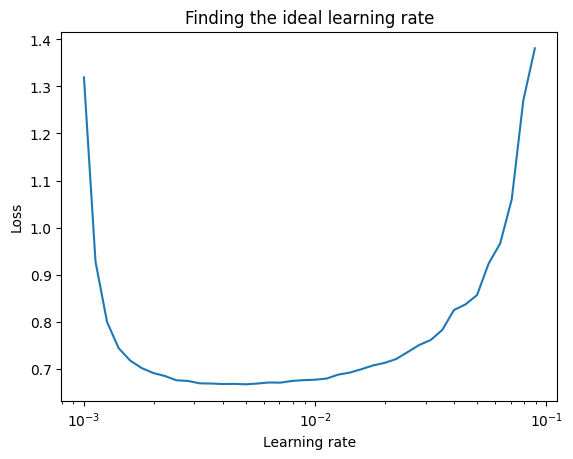

In [ ]:
# Vẽ đường cong suy giảm tốc độ học
import numpy as np
import matplotlib.pyplot as plt
lrs = 1e-3 * (10**(np.arange(40)/20))
plt.semilogx(lrs, find_lr_history.history["loss"]) # cần trục x theo thang log
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.title("Finding the ideal learning rate");

Trong trường hợp này, nó trông khá sát với tốc độ học của [thuật toán tối ưu Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam), (`0.001`) là tốc độ học lý tưởng.

Hãy khớp lại mô hình với tốc độ học lý tưởng.

In [ ]:
# Thiết lập random seed
tf.random.set_seed(42)

# Tạo mô hình
model_14 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)), # lớp đầu vào (cần reshape 28x28 thành 784)
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(10, activation="softmax") # output shape là 10, activation là softmax
])

# Biên dịch mô hình
model_14.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # tốc độ học lý tưởng (giống mặc định)
                 metrics=["accuracy"])

# Khớp mô hình
history = model_14.fit(train_data,
                       train_labels,
                       epochs=20,
                       validation_data=(test_data, test_labels))

Epoch 1/20
1875/1875 [==============================] - 7s 3ms/step - loss: 1.0934 - accuracy: 0.6190 - val_loss: 0.8369 - val_accuracy: 0.7396
Epoch 2/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.7477 - accuracy: 0.7655 - val_loss: 0.7400 - val_accuracy: 0.7651
Epoch 3/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6488 - accuracy: 0.7900 - val_loss: 0.6462 - val_accuracy: 0.7898
Epoch 4/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5991 - accuracy: 0.8051 - val_loss: 0.6186 - val_accuracy: 0.7969
Epoch 5/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5758 - accuracy: 0.8086 - val_loss: 0.6238 - val_accuracy: 0.7901
Epoch 6/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5558 - accuracy: 0.8137 - val_loss: 0.6020 - val_accuracy: 0.7993
Epoch 7/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5428 - accuracy: 0.8182 - val_loss: 0.5805 - val_accuracy:

Chúng ta có một mô hình được huấn luyện với tốc độ học gần như lý tưởng, hoạt động rất tốt và một vài lựa chọn.

Chúng ta có thể:
* Đánh giá chất lượng bằng một phép đo phân loại khác ([confusion matrix](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py) hoặc [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)).
* Đánh giá một số dự đoán của mô hình (bằng cách trực quan).
* Cải thiện độ chính xác (huấn luyện lâu hơn hoặc thay đổi kiến trúc).
* Lưu và xuất để dùng nó trong ứng dụng.

Hãy xem xét hai tùy chọn đầu tiên.

Trước tiên chúng ta sẽ tạo một ma trận phân loại để hiển thị dự đoán trên các lớp khác nhau.

In [23]:
# Lưu ý: Code sau của confusion matrix là bản phối lại của Scikit-Learn giữa
# hàm plot_confusion_matrix - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
# và notebook giới thiệu của Made with ML - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
import itertools
from sklearn.metrics import confusion_matrix

# Hàm cần một tên khác cho plot_confusion_matrix của sklearn
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15):
  """Tạo một confusion matrix đã dán nhãn so sánh với các dự đoán và nhãn gốc.

  Nếu lớp được truyền, confusion matrix sẽ được gắn nhãn, nếu không sẽ dùng các giá trị integer class.


  Đối số:
    y_true: Mảng gồm các truth label (phải có shape giống với y_pred).
    y_pred: Mảng gồm các nhãn đã được dự đoán (phải có shape giống với y_true).
    classes: Mảng gồm các nhãn lớp (chẳng hạn: dạng string). Nếu là `None` sẽ dùng các nhãn số nguyên.
    figsize: Kích thước của output figure (default=(10, 10)).
    text_size: Kích thước của văn bản output figure (default=15).

  Trả về:
    Biểu đồ confusion matrix đã dán nhãn so với y_true và y_pred.

  Ví dụ:
    make_confusion_matrix(y_true=test_labels, # nhãn gốc test_label
                          y_pred=y_preds, # nhãn đã đoán
                          classes=class_names, # mảng gồm tên nhãn lớp
                          figsize=(15, 15),
                          text_size=10)
  """
  # Tạo confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Vẽ figure và chỉnh cho nó đẹp hơn
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # màu sắc thể hiện độ 'đúng' của một lớp, càng đậm tức là càng tốt hơn
  fig.colorbar(cax)

  # Có danh sách các lớp không?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Dán nhãn các trục
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # tạo đủ trục cho từng lớp
         yticks=np.arange(n_classes),
         xticklabels=labels, # các trục sẽ được gắn nhãn tên lớp (nếu chúng tồn tại) hoặc int
         yticklabels=labels)

  # Làm cho các nhãn trục x xuất hiện ở dưới cùng
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Thiết lập ngưỡng cho các màu khác nhau
  threshold = (cm.max() + cm.min()) / 2.

  # Lập biểu đồ văn bản ở từng cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

Do confusion matrix so sánh nhãn đúng (`test_labels`) với các nhãn được dự đoán nên chúng ta cần đưa ra dự đoán với mô hình.

In [29]:
# Đưa ra dự đoán với mô hình gần đây nhất
y_probs = model_14.predict(test_data) # "probs" là viết tắt của probabilities (xác suất)

# Xem 5 dự đoán đầu tiên
y_probs[:5]

313/313 [==============================] - 1s 3ms/step


array([[1.01574360e-09, 9.70290717e-18, 1.26452964e-14, 1.52175202e-13,
        1.37980294e-10, 2.94176534e-05, 1.18588805e-09, 6.90966612e-04,
        2.10500084e-09, 9.99279737e-01],
       [3.33690969e-06, 1.20211564e-16, 9.99715447e-01, 4.15685086e-09,
        2.73692334e-04, 8.63285751e-24, 7.47782724e-06, 1.71874276e-30,
        1.02930046e-10, 5.43756917e-34],
       [3.67989173e-22, 9.99999940e-01, 4.30933614e-32, 8.52577836e-20,
        2.71605390e-22, 0.00000000e+00, 3.49925540e-26, 0.00000000e+00,
        1.22590433e-36, 0.00000000e+00],
       [2.10883326e-24, 9.99999940e-01, 6.79138509e-34, 1.78659742e-18,
        1.97994949e-22, 0.00000000e+00, 1.71143004e-25, 0.00000000e+00,
        4.10028585e-37, 0.00000000e+00],
       [2.10897639e-01, 5.69956612e-16, 3.53844813e-03, 1.08207843e-08,
        3.10621195e-04, 1.36585931e-09, 7.85253227e-01, 1.07657145e-12,
        9.96086200e-08, 7.71032493e-15]], dtype=float32)

Mô hình của chúng ta xuất ra một danh sách **xác suất dự đoán**, tức là nó xuất ra các số cho biết khả năng một lớp cụ thể là nhãn.

Số trong danh sách xác suất càng cao thì mô hình càng tin đó là lớp đúng.

Để tìm giá trị cao nhất, hãy sử dụng phương thức [`argmax()`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html).

In [30]:
# Xem số lớp đã dự đoán và nhãn cho mẫu đầu tiên
y_probs[0].argmax(), class_names[y_probs[0].argmax()]

(9, 'Ankle boot')

Thực hiện tương tự với toàn bộ dự đoán.

In [31]:
# Chuyển toàn bộ dự đoán từ xác suất thành nhãn
y_preds = y_probs.argmax(axis=1)

# Xem 10 dự đoán đầu tiên
y_preds[:10]

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

Chúng ta đã thu được các dự đoán của mô hình ở dạng nhãn, hãy tạo một confusion matrix để xem chúng so với nhãn đúng.

In [32]:
# Kiểm tra confusion matrix không được làm đẹp
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true=test_labels,
                 y_pred=y_preds)

array([[842,   1,   8,  35,   5,   1, 101,   0,   7,   0],
       [  2, 964,   2,  21,   4,   0,   3,   1,   3,   0],
       [ 18,   0, 807,  14, 114,   0,  46,   0,   1,   0],
       [ 14,   6,   8, 909,  45,   0,  13,   0,   5,   0],
       [  0,   0,  78,  20, 869,   0,  30,   0,   3,   0],
       [  0,   0,   0,   0,   0, 959,   0,  23,   2,  16],
       [114,   0,  98,  43, 101,   0, 636,   0,   8,   0],
       [  0,   0,   0,   0,   0,   8,   0, 979,   0,  13],
       [  6,   0,   1,   5,   6,   2,   2,   2, 976,   0],
       [  1,   0,   0,   0,   0,   6,   0,  41,   0, 952]])

Confusion matrix đó khá khó hiểu, hãy làm cho nó dễ nhìn hơn bằng cách sử dụng hàm mà chúng ta đã tạo trước đó.

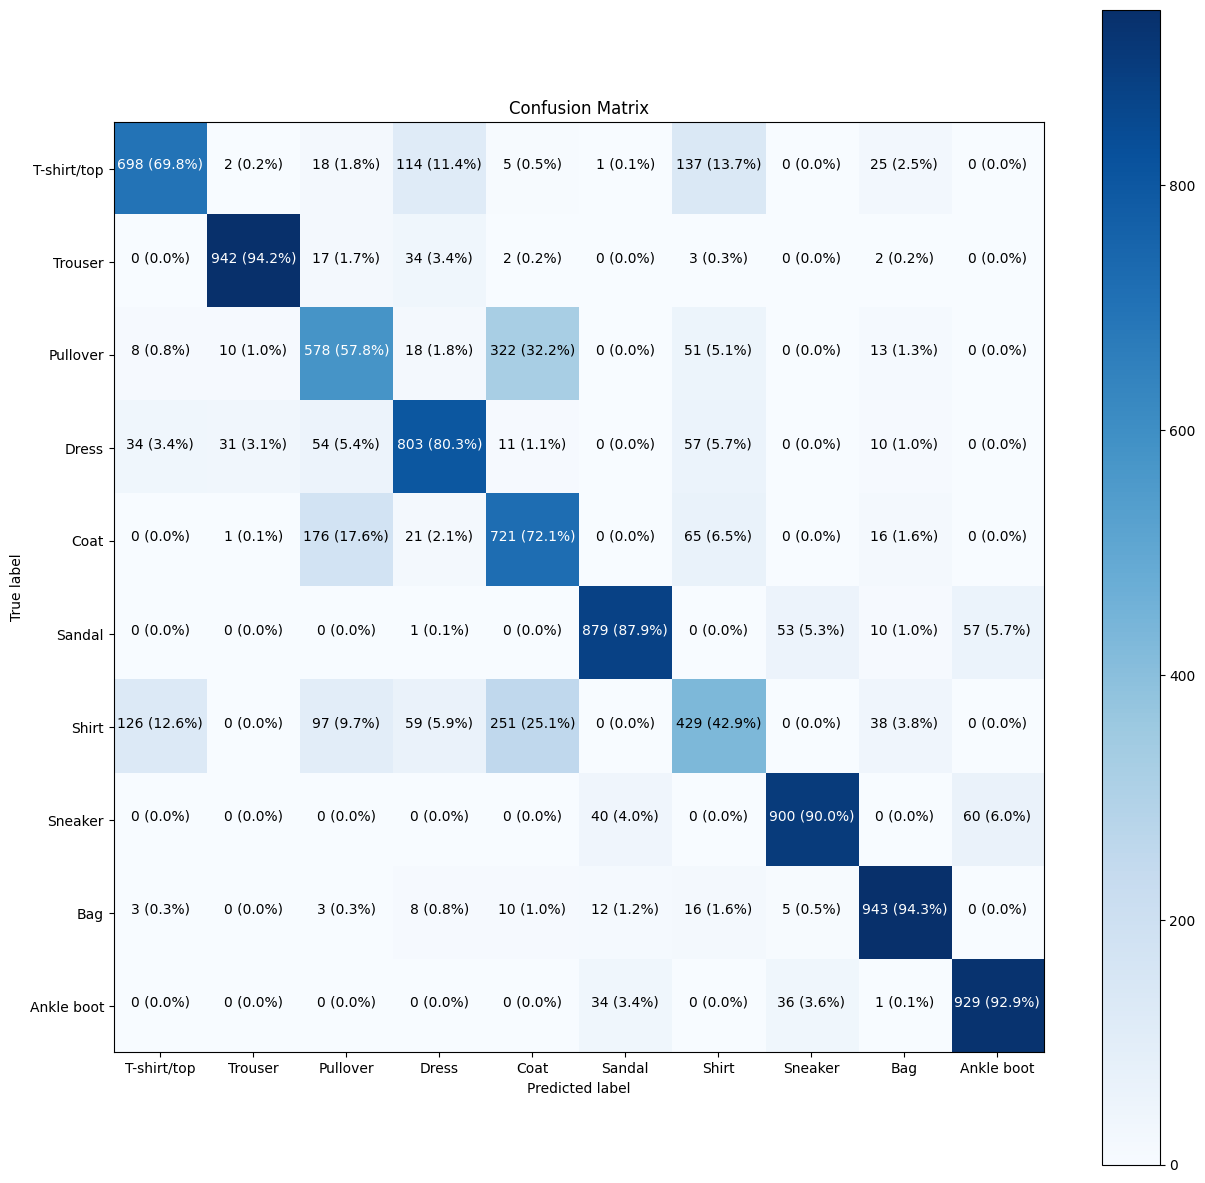

In [ ]:
# Tạo confusion matrix đẹp hơn
make_confusion_matrix(y_true=test_labels,
                      y_pred=y_preds,
                      classes=class_names,
                      figsize=(15, 15),
                      text_size=10)

Trông tốt hơn nhiều rồi! (một trong những điểm nhìn yêu thích của tôi là confusion matrix với các ô vuông tối theo đường chéo).

Ngoại trừ kết quả không tốt như mong đợi ...

Có vẻ như mô hình của chúng ta đang bị nhầm lẫn giữa các lớp `Shirt` và `T-shirt/top` (ví dụ: dự đoán là `Shirt` trong khi đó thực ra là `T-shirt/top`).

> 🤔 **Câu hỏi:** Có phải mô hình của chúng ta đang bị nhầm lẫn giữa các lớp `Shirt` và `T-shirt/top` không? Tại sao bạn nghĩ rằng điều này có thể xảy ra? Làm thế nào để kiểm tra?

Chúng ta đã thấy cách các dự đoán mô hình sắp xếp theo truth label bằng cách sử dụng confusion matrix, nhưng làm thế nào để hình dung một vài dự đoán?

Hãy tạo một hàm để vẽ ảnh ngẫu nhiên cùng với dự đoán của nó.

> 🔑 **Lưu ý:** Thông thường khi làm việc với hình ảnh và các dạng dữ liệu trực quan khác, chúng ta nên trực quan hóa càng nhiều càng tốt để hiểu thêm về dữ liệu và kết quả đầu ra của mô hình.

In [ ]:
import random

# Tạo hàm vẽ ảnh ngẫu nhiên cùng với các dự đoán của nó
def plot_random_image(model, images, true_labels, classes):
  """Chọn một ảnh ngẫu nhiên, vẽ và dán nhãn nó với nhãn đúng và nhãn đã dự đoán.

  Đối số:
    model: mô hình đã huấn luyện (huấn luyện trên dữ liệu tương tự với dữ liệu trong ảnh.)
    images: tập hợp các ảnh ngẫu nhiên (ở dạng tensor).
    true_labels: mảng các nhãn gốc cho ảnh.
    classes: mảng các tên lớp cho anhe.

  Trả về:
    Biểu đồ ảnh ngẫu nhiên từ `images` với nhãn lớp đã dự đoán từ `model`
    cũng như nhãn lớp đúng từ `true_labels`.
  """
  # Thiết lập random integer
  i = random.randint(0, len(images))

  # Tạo các mục tiêu và dự đoán
  target_image = images[i]
  pred_probs = model.predict(target_image.reshape(1, 28, 28)) # cần reshape để mô hình có đúng kích thước
  pred_label = classes[pred_probs.argmax()]
  true_label = classes[true_labels[i]]

  # Vẽ ảnh mục tiêu
  plt.imshow(target_image, cmap=plt.cm.binary)

  # Thay đổi màu của tiêu đề tùy xem dự đoán đúng hay sai
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Thêm thông tin xlabel (prediction/true label)
  plt.xlabel("Pred: {} {:2.0f}% (True: {})".format(pred_label,
                                                   100*tf.reduce_max(pred_probs),
                                                   true_label),
             color=color) # đặt color là green hoặc red

1/1 [==============================] - 0s 20ms/step


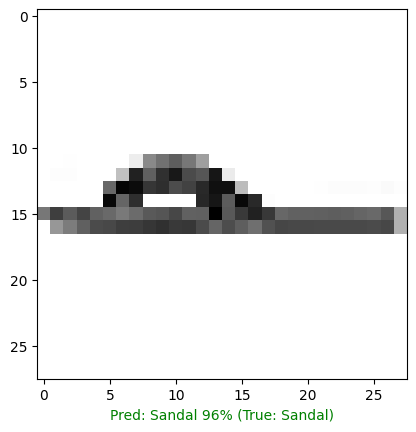

In [ ]:
# Kiểm tra ảnh ngẫu nhiên cũng như dự đoán của nó
plot_random_image(model=model_14,
                  images=test_data,
                  true_labels=test_labels,
                  classes=class_names)

Sau khi chạy cell trên một vài lần, chúng ta sẽ bắt đầu hiểu được mối quan hệ giữa các dự đoán của mô hình và các nhãn thực.

Bạn có thấy dự đoán nào mà mô hình bị nhầm lẫn không?

Dường như nó đang nhầm các lớp tương tự nhau, ví dụ: `Sneaker` với `Ankle boot`.

Nhìn vào hình ảnh, chúng ta có thể thấy trường hợp này xảy ra thế nào.

Shape tổng thể của `Sneaker` và `Ankle Boot` tương tự nhau.

Shape tổng thể có thể là một trong những pattern mà mô hình học được, do đó khi hai hình ảnh có shape giống nhau, các dự đoán của chúng sẽ bị nhầm lẫn.

### Mô hình của chúng ta đang học những pattern nào?

Chúng ta đã nói rất nhiều về cách mạng nơ-ron tìm thấy pattern ở dạng số, nhưng chính xác thì các pattern này trông như thế nào?

Hãy mở một mô hình và tìm hiểu.

Đầu tiên, chúng ta sẽ nhận được danh sách các layer của mô hình gần đây nhất (`model_14`) bằng cách sử dụng thuộc tính `layers`.

In [ ]:
# Tìm các layer của mô hình gần đây nhất
model_14.layers

Chúng ta có thể truy cập layer mục tiêu bằng cách lập chỉ mục.

In [ ]:
# Trích xuất một layer cụ thể
model_14.layers[1]

Chúng ta có thể tìm ra các pattern được học bởi một layer cụ thể bằng phương thức `get_weights()`.

Phương thức `get_weights()` trả về **trọng số**  (còn được gọi là ma trận trọng số) và độ lệch (còn được gọi là vectơ độ chệch) của một layer cụ thể.

In [ ]:
# Lấy các pattern của một layer trong mạng
weights, biases = model_14.layers[1].get_weights()

# Shape = 1 ma trận trọng số kích thước của dữ liệu đầu vào (28x28) mỗi nơ-ron (4)
weights, weights.shape

(array([[-0.77516156, -0.67969793,  0.96130717, -0.01320435],
        [-0.4414811 , -1.2161359 ,  0.5081636 , -0.01548988],
        [-0.83346   , -0.8878968 ,  0.9910525 , -0.07894742],
        ...,
        [-0.19208236, -0.31497175,  0.02025419,  0.07096779],
        [ 0.10604584, -0.11742623, -0.4824464 ,  0.07053004],
        [-0.28794387, -0.31259978,  0.20638306, -0.01538216]],
       dtype=float32),
 (784, 4))

Ma trận trọng số có cùng shape với dữ liệu đầu vào, trong trường hợp này là 784 (28x28 pixel). Và có một bản sao của ma trận trọng số cho mỗi nơ-ron trong layer đã chọn (layer đã chọn có 4 nơ-ron).

Mỗi giá trị trong ma trận trọng số tương ứng với cách một giá trị cụ thể trong dữ liệu đầu vào ảnh hưởng đến các quyết định của mạng.

Các giá trị này bắt đầu dưới dạng số ngẫu nhiên (được thiết lập bởi [tham số `kernel_initializer`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) khi tạo layer, mặc định là [`"glorot_uniform"`](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/GlorotUniform)), sau đó được cập nhật thành các giá trị biểu diễn tốt hơn của dữ liệu (không ngẫu nhiên) bởi mạng nơ-ron trong quá trình huấn luyện.

![neural network supervised learning weight updates](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-fashion-mnist-learning.png)
*Quy trình mẫu: cách mạng nơ-ron có giám sát bắt đầu với trọng số ngẫu nhiên và cập nhật chúng để biểu diễn dữ liệu tốt hơn bằng cách xem xét các mẫu đầu ra lý tưởng.*

Bây giờ, hãy kiểm tra vectơ độ chệch.

In [ ]:
# Shape = 1 bias mỗi nơ-ron (chúng ta sử dụng 4 nơ-ron ở layer đầu tiên)
biases, biases.shape

(array([ 0.77431476, -0.6652483 , -0.00292598, -0.03923208], dtype=float32),
 (4,))

Mỗi nơ-ron lại có một vectơ độ chệch. Mỗi vectơ độ chệch được ghép nối với một ma trận trọng số.

Các giá trị độ chệch được khởi tạo bằng 0 theo mặc định (sử dụng [tham số `bias_initializer`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)).

Vectơ độ chệch chỉ ra mức độ ảnh hưởng của các pattern trong ma trận trọng số tương ứng với layer kế tiếp.

In [ ]:
# Tính số lượng tham số trong mô hình
model_14.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_37 (Dense)            (None, 4)                 3140      
                                                                 
 dense_38 (Dense)            (None, 4)                 20        
                                                                 
 dense_39 (Dense)            (None, 10)                50        
                                                                 
Total params: 3210 (12.54 KB)
Trainable params: 3210 (12.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Bây giờ chúng ta đã xây dựng một vài mô hình học sâu, đây là thời điểm tốt để chỉ ra rằng toàn bộ khái niệm đầu vào và đầu ra không chỉ liên quan đến mô hình nói chung mà còn liên quan tới *mọi* layer trong mô hình.

Bạn có thể đã đoán được điều này, nhưng bắt đầu từ layer đầu vào, đầu vào của mỗi layer tiếp theo sẽ là đầu ra của layer trước đó.

Chúng ta có thể thấy rõ điều này bằng cách sử dụng [`plot_model()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model).

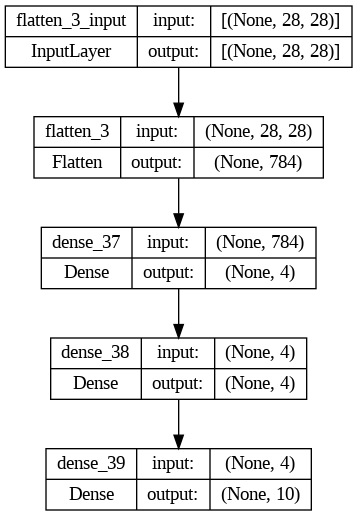

In [ ]:
from tensorflow.keras.utils import plot_model

# Xem đầu vào và đầu ra của từng layer
plot_model(model_14, show_shapes=True)

## Cách mô hình học (tóm tắt)

Chúng ta đã huấn luyện rất nhiều mô hình, nhưng chưa bao giờ thực sự thảo luận sâu về nó. Vậy chính xác thì một mô hình học như thế nào?

Mô hình học bằng cách cập nhật và cải thiện ma trận trọng số và giá trị độ chệch mỗi epoch (trong trường hợp này, chúng ta gọi hàm `fit()`).

Nó thực hiện bằng cách so sánh các pattern đã học giữa dữ liệu và nhãn với nhãn thực tế.

Nếu các pattern hiện tại (ma trận trọng số và giá trị độ chệch) không làm giảm hàm mất mát mong muốn (loss cao hơn nghĩa là dự đoán tệ hơn) thì optimizer sẽ cố gắng hướng mô hình cập nhật các pattern theo cách phù hợp (sử dụng giá trị thực nhãn làm tham chiếu).

Quá trình sử dụng các nhãn thực làm tham chiếu để cải thiện các dự đoán của mô hình được gọi là [**backpropagation (lan truyền ngược)**](https://en.wikipedia.org/wiki/Backpropagation).

Nói cách khác, dữ liệu và nhãn truyền qua một mô hình (**truyền xuôi**) và nó cố gắng tìm hiểu mối quan hệ giữa dữ liệu và nhãn.

Và nếu mối quan hệ tìm hiểu được này không gần với mối quan hệ thực tế hoặc nó có thể cải thiện, thì mô hình sẽ tự quay lại (**truyền ngược**), điều chỉnh ma trận trọng số và giá trị độ chệch để biểu diễn dữ liệu tốt hơn.

Nếu tất cả những điều này còn khó hiểu (không sao cả, ở trên là mô tả rất ngắn gọn), hãy xem tài liệu trong phần Tài liệu tham khảo để biết thêm.

## 🛠 Bài tập thực hành
> **Lưu ý:** Các bạn cần làm phần bài tập này để chuẩn bị cho phiên review lab.

1. Luyện tập với mạng nơ-ron khoảng 10 phút trong [TensorFlow Playground](https://playground.tensorflow.org/). Hãy thử các giá trị learning rate khác nhau và xem điều gì sẽ xảy ra nếu tăng hoặc giảm các giá trị này.
2. Sao chép mô hình trong hình sau ở [TensorFlow Playground diagram](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.001&regularizationRate=0&noise=0&networkShape=6,6,6,6,6&seed=0.51287&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&discretize_hide=true&regularizationRate_hide=true&percTrainData_hide=true&dataset_hide=true&problem_hide=true&noise_hide=true&batchSize_hide=true) bằng code của TensorFlow. Biên dịch nó với Adam optimizer, binary cross-entropy loss và accuracy; sau đó kiểm tra bản tóm tắt của mô hình.
![tensorflow playground example neural network](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-tensorflow-playground-replication-exercise.png)

*Thử mạng này trong [TensorFlow Playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.001&regularizationRate=0&noise=0&networkShape=6,6,6,6,6&seed=0.51287&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&discretize_hide=true&regularizationRate_hide=true&percTrainData_hide=true&dataset_hide=true&problem_hide=true&noise_hide=true&batchSize_hide=true). Gợi ý: có 5 lớp ẩn nhưng lớp đầu ra không được mô tả, các bạn cần quyết định lớp đầu ra dựa trên dữ liệu đầu vào.*

3. Tạo một tập dữ liệu phân loại bằng hàm [`make_moons()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) của Scikit-learn, trực quan hóa nó rồi xây dựng một mô hình để khớp với độ chính xác trên 85%.
4. Tạo một hàm (hoặc viết code) để hiển thị đồng thời nhiều dự đoán hình ảnh cho fashion MNIST. Lập biểu đồ ít nhất 3 hình ảnh khác nhau và nhãn dự đoán của chúng cùng một lúc.
5. Tạo lại [hàm softmax](https://en.wikipedia.org/wiki/Softmax_function) của [TensorFlow](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) trong code riêng của bạn. Đảm bảo nó có thể chấp nhận tensor và trả về tensor sau khi áp dụng hàm softmax.
6. Huấn luyện mô hình để đạt được độ chính xác trên 88% trên tập kiểm tra fashion MNIST. Sau đó, lập biểu đồ confusion matrix để xem kết quả.
7. Tạo hàm để hiển thị hình ảnh của một lớp nhất định trong tập dữ liệu fashion MNIST và đưa ra dự đoán trên đó. Ví dụ: vẽ 3 hình của lớp `T-shirt` với các dự đoán của chúng.



2. Sao chép mô hình trong hình sau ở [TensorFlow Playground diagram](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.001&regularizationRate=0&noise=0&networkShape=6,6,6,6,6&seed=0.51287&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&discretize_hide=true&regularizationRate_hide=true&percTrainData_hide=true&dataset_hide=true&problem_hide=true&noise_hide=true&batchSize_hide=true) bằng code của TensorFlow. Biên dịch nó với Adam optimizer, binary cross-entropy loss và accuracy; sau đó kiểm tra bản tóm tắt của mô hình.

In [ ]:
tf.random.set_seed(10)

playground_model = tf.keras.Sequential([
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


playground_model.compile(loss=tf.keras.losses.binary_crossentropy,
                         optimizer=tf.keras.optimizers.Adam(),
                         metrics='accuracy')

In [ ]:
playground_model.fit(X,y,epochs=5)

Epoch 1/5
32/32 [==============================] - 1s 2ms/step - loss: 0.6964 - accuracy: 0.4930
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 0.6949 - accuracy: 0.4600
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 0.6939 - accuracy: 0.4650
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4820
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5000


In [ ]:
playground_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 6)                 18        
                                                                 
 dense_41 (Dense)            (None, 6)                 42        
                                                                 
 dense_42 (Dense)            (None, 6)                 42        
                                                                 
 dense_43 (Dense)            (None, 6)                 42        
                                                                 
 dense_44 (Dense)            (None, 6)                 42        
                                                                 
 dense_45 (Dense)            (None, 1)                 7         
                                                                 
Total params: 193 (772.00 Byte)
Trainable params: 193

3. Tạo một tập dữ liệu phân loại bằng hàm [`make_moons()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) của Scikit-learn, trực quan hóa nó rồi xây dựng một mô hình để khớp với độ chính xác trên 85%.

In [ ]:
from sklearn.datasets import make_moons
# Tạo 100 mẫu
n_samples = 1000

# Tạo circles
X, y = make_moons(n_samples,
                    noise=0.03,
                    random_state=42)

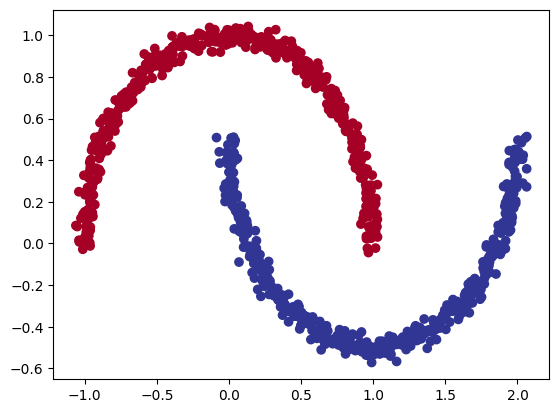

In [ ]:
moons = pd.DataFrame({"X0":X[:, 0], "X1":X[:, 1], "label":y})
moons.head()
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [ ]:
tf.random.set_seed(20)

moons_model = tf.keras.Sequential([
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


moons_model.compile(loss=tf.keras.losses.binary_crossentropy,
                         optimizer=tf.keras.optimizers.Adam(),
                         metrics='accuracy')

In [ ]:
playground_model.fit(X,y,epochs=5)

Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5050
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 0.6753 - accuracy: 0.7370
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 0.5955 - accuracy: 0.8320
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 0.4652 - accuracy: 0.8440
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 0.3480 - accuracy: 0.8650


4. Tạo một hàm (hoặc viết code) để hiển thị đồng thời nhiều dự đoán hình ảnh cho fashion MNIST. Lập biểu đồ ít nhất 3 hình ảnh khác nhau và nhãn dự đoán của chúng cùng một lúc.


In [9]:
import numpy as np

In [ ]:
import random

# Tạo hàm vẽ ảnh ngẫu nhiên cùng với các dự đoán của nó
def plot_random_images(model, images, true_labels, classes):
  """Chọn một ảnh ngẫu nhiên, vẽ và dán nhãn nó với nhãn đúng và nhãn đã dự đoán.

  Đối số:
    model: mô hình đã huấn luyện (huấn luyện trên dữ liệu tương tự với dữ liệu trong ảnh.)
    images: tập hợp các ảnh ngẫu nhiên (ở dạng tensor).
    true_labels: mảng các nhãn gốc cho ảnh.
    classes: mảng các tên lớp cho anhe.

  Trả về:
    Biểu đồ ảnh ngẫu nhiên từ `images` với nhãn lớp đã dự đoán từ `model`
    cũng như nhãn lớp đúng từ `true_labels`.
  """
  # Thiết lập random integer
  sample_img = np.random.randint(0, len(images), size=4)
  plt.figure(figsize=(7, 7))
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(test_data[sample_img[i]], cmap=plt.cm.binary)
    # Tạo các mục tiêu và dự đoán
    target_image = images[sample_img[i]]
    pred_probs = model.predict(target_image.reshape(1, 28, 28)) # cần reshape để mô hình có đúng kích thước
    pred_label = classes[pred_probs.argmax()]
    true_label = classes[true_labels[sample_img[i]]]

  # Vẽ ảnh mục tiêu

  # Thay đổi màu của tiêu đề tùy xem dự đoán đúng hay sai
    if pred_label == true_label:
      color = "green"
    else:
      color = "red"

    # Thêm thông tin xlabel (prediction/true label)
    plt.xlabel("Pred: {} {:2.0f}% (True: {})".format(pred_label,
                                                    100*tf.reduce_max(pred_probs),
                                                    true_label),
              color=color) # đặt color là green hoặc red

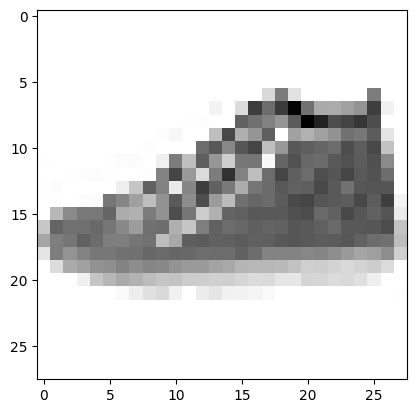

In [ ]:
sam_img = np.random.randint(0, len(test_data), size=3)
for i in sam_img:
  plt.imshow(test_data[i], cmap=plt.cm.binary)

1/1 [==============================] - 0s 21ms/step


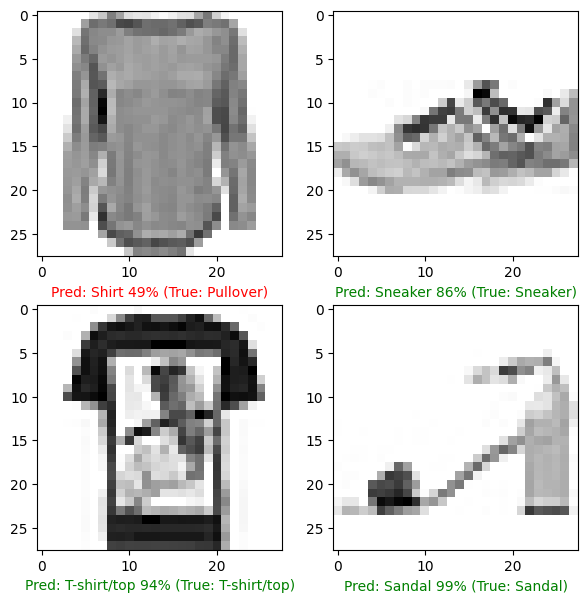

In [ ]:
plot_random_images(model=model_14,
                  images=test_data,
                  true_labels=test_labels,
                  classes=class_names)

5. Tạo lại [hàm softmax](https://en.wikipedia.org/wiki/Softmax_function) của [TensorFlow](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) trong code riêng của bạn. Đảm bảo nó có thể chấp nhận tensor và trả về tensor sau khi áp dụng hàm softmax.

In [18]:
def tensor_softmax(input):
  sum_exp = np.sum(np.exp(input))
  return tf.constant(np.exp(input)/sum_exp)

In [19]:
tensor1 = [1,2,3]
tensor_softmax(tensor1)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([0.09003057, 0.24472847, 0.66524096])>

6. Huấn luyện mô hình để đạt được độ chính xác trên 88% trên tập kiểm tra fashion MNIST. Sau đó, lập biểu đồ confusion matrix để xem kết quả.

In [27]:
# Thiết lập random seed
tf.random.set_seed(42)

# Tạo mô hình
model_14 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)), # lớp đầu vào (cần reshape 28x28 thành 784)
  tf.keras.layers.Dense(500, activation="relu"),
  tf.keras.layers.Dense(100, activation="relu"),
  tf.keras.layers.Dense(10, activation="softmax") # output shape là 10, activation là softmax
])

# Biên dịch mô hình
model_14.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.002), # tốc độ học lý tưởng (giống mặc định)
                 metrics=["accuracy"])



In [28]:
# Khớp mô hình
history = model_14.fit(train_data,
                       train_labels,
                       epochs=20,
                       validation_data=(test_data, test_labels))

Epoch 1/20
1875/1875 [==============================] - 17s 9ms/step - loss: 0.4820 - accuracy: 0.8249 - val_loss: 0.3995 - val_accuracy: 0.8569
Epoch 2/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.3685 - accuracy: 0.8645 - val_loss: 0.4394 - val_accuracy: 0.8520
Epoch 3/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.3352 - accuracy: 0.8761 - val_loss: 0.4038 - val_accuracy: 0.8575
Epoch 4/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.3139 - accuracy: 0.8852 - val_loss: 0.3658 - val_accuracy: 0.8649
Epoch 5/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.2960 - accuracy: 0.8905 - val_loss: 0.3775 - val_accuracy: 0.8622
Epoch 6/20
1875/1875 [==============================] - 16s 9ms/step - loss: 0.2833 - accuracy: 0.8935 - val_loss: 0.3878 - val_accuracy: 0.8540
Epoch 7/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.2713 - accuracy: 0.8991 - val_loss: 0.3640 - val_ac

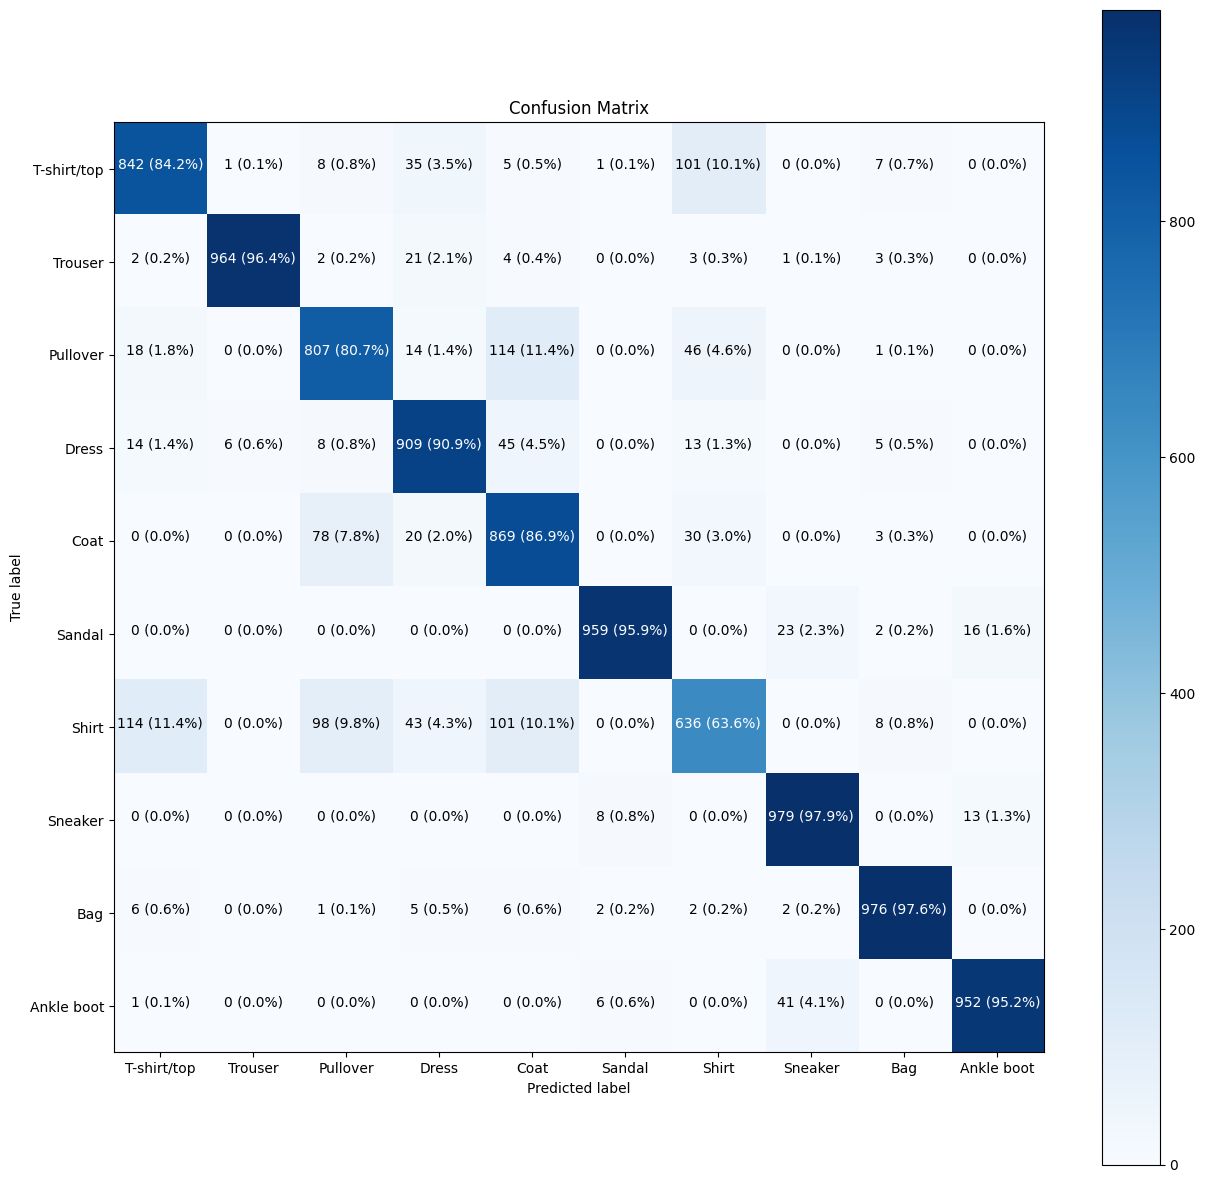

In [33]:
# Tạo confusion matrix đẹp hơn
make_confusion_matrix(y_true=test_labels,
                      y_pred=y_preds,
                      classes=class_names,
                      figsize=(15, 15),
                      text_size=10)

7. Tạo hàm để hiển thị hình ảnh của một lớp nhất định trong tập dữ liệu fashion MNIST và đưa ra dự đoán trên đó. Ví dụ: vẽ 3 hình của lớp `T-shirt` với các dự đoán của chúng.

In [88]:
import random

# Tạo hàm vẽ ảnh ngẫu nhiên cùng với các dự đoán của nó
def plot_random_class(model, images, true_labels, classes):
  """Chọn một ảnh ngẫu nhiên, vẽ và dán nhãn nó với nhãn đúng và nhãn đã dự đoán.

  Đối số:
    model: mô hình đã huấn luyện (huấn luyện trên dữ liệu tương tự với dữ liệu trong ảnh.)
    images: tập hợp các ảnh ngẫu nhiên (ở dạng tensor).
    true_labels: mảng các nhãn gốc cho ảnh.
    classes: mảng các tên lớp cho anhe.

  Trả về:
    Biểu đồ ảnh ngẫu nhiên từ `images` với nhãn lớp đã dự đoán từ `model`
    cũng như nhãn lớp đúng từ `true_labels`.
  """
  # Thiết lập random integer
  random_class = np.random.randint(0, len(classes))
  class_img = [images[picture] for picture in range(len(images)) if class_names[true_labels[picture]]==class_names[random_class]]
  sample_img = np.random.randint(0, len(class_img), size=4)
  plt.figure(figsize=(7, 7))
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(class_img[sample_img[i]], cmap=plt.cm.binary)
    # Tạo các mục tiêu và dự đoán
    target_image = class_img[sample_img[i]]
    pred_probs = model.predict(target_image.reshape(1, 28, 28)) # cần reshape để mô hình có đúng kích thước
    pred_label = classes[pred_probs.argmax()]
    true_label = classes[random_class]

  # Vẽ ảnh mục tiêu

  # Thay đổi màu của tiêu đề tùy xem dự đoán đúng hay sai
    if pred_label == true_label:
      color = "green"
    else:
      color = "red"

    # Thêm thông tin xlabel (prediction/true label)
    plt.xlabel("Pred: {} {:2.0f}% (True: {})".format(pred_label,
                                                    100*tf.reduce_max(pred_probs),
                                                    true_label),
              color=color) # đặt color là green hoặc red

1/1 [==============================] - 0s 39ms/step


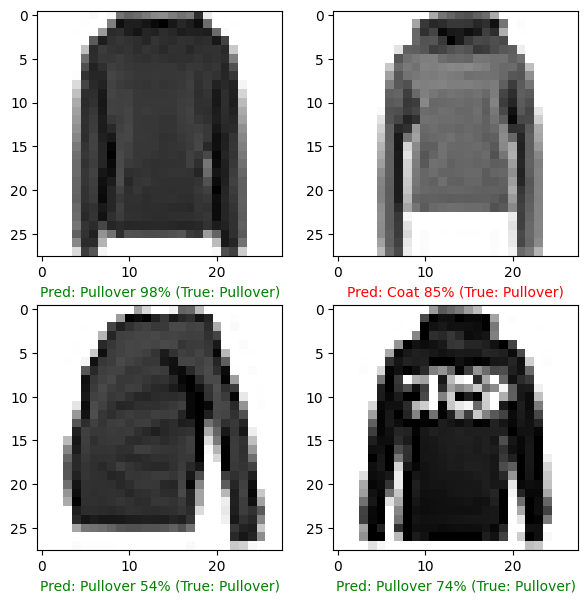

In [89]:
plot_random_class(model=model_14,
                  images=test_data,
                  true_labels=test_labels,
                  classes=class_names)

In [80]:
random_class = np.random.randint(0, len(class_names))
names = class_names[random_class]
# sam_img = np.random.randint(0, len(class_names[test_data]), size=3)
# for i in sam_img:
#   plt.imshow(test_data[i], cmap=plt.cm.binary)
#   plt.title(class_names[test_labels[i]])
class_test_data = [test_data[picture] for picture in range(len(test_data)) if class_names[test_labels[picture]]==names]

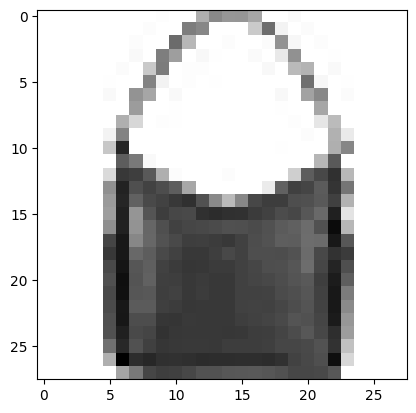

In [85]:
plt.imshow(class_test_data[3], cmap=plt.cm.binary)

## Tài liệu đọc thêm 📖
* Xem video số 2 về mạng nơ-ron của 3Blue1Brown: [*Gradient descent, how neural networks learn*](https://www.youtube.com/watch?v=IHZwWFHWa-w). Sau đó, viết khoảng 100 từ về những gì bạn học được.
  *  Nếu chưa sẵn sàng, hãy xem video 1: [*But what is a Neural Network?*](https://youtu.be/aircAruvnKk). Lưu ý hàm kích hoạt mà họ nói tới ở cuối.
* Xem video [MIT's introduction to deep learning lecture 1](https://youtu.be/njKP3FqW3Sk) (nếu chưa sẵn sàng) để hiểu các khái niệm sau việc sử dụng các hàm tuyến tính và phi tuyến tính.
*  Dành 1 giờ đọc cuốn sách [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/index.html) (Michael Nielsen).
* Đọc tài liệu về [activation functions của ML Glossary](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html). Bạn thích phần nào nhất?
  * Sau khi đọc xong ML-Glossary, hãy tìm "tensorflow activation functions" để xem hàm kích hoạt nào có sẵn trong TensorFlow.